In [1]:
import pandas as pd

df_ae = pd.read_csv('/content/drive/MyDrive/differential_learning/gait_ae_dataset.csv')
df_dtw = pd.read_csv('/content/drive/MyDrive/differential_learning/subject_dtw_scores.csv')
df_for = pd.read_csv('/content/drive/MyDrive/differential_learning/subject_forecast_scores.csv')

df_ae.drop(columns=['Unnamed: 0'], inplace=True)

df_ae.head()

subject          trial  reconstruction_error  learning_index
0     S02  S02_0002_Gait              0.135647        0.018941
1     S02  S02_0003_Gait              0.153889        0.018941
2     S02  S02_0004_Gait              0.101571        0.018941
3     S02  S02_0005_Gait              0.115353        0.018941
4     S02  S02_0006_Gait              0.158526        0.018941

In [2]:
df_dtw.head()

subject_id  final_dtw                                          dtw_curve
0           1  30.942326  [22.044224474928342, 18.935448204400018, 20.67...
1           2   0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2           3   0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3           4  34.392516  [19.789006422273815, 21.55911359912716, 24.202...
4           5   0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [3]:
df_for.head()

subject_id    real_slope  pred_slope  slope_gap
0           1  5.269888e-03    0.001819   0.003451
1           2  4.899321e-08   -0.000169   0.000169
2           3 -1.897640e-08   -0.000169   0.000169
3           4 -1.340096e-02   -0.001194   0.012207
4           5 -1.051566e-18   -0.000169   0.000169

In [4]:
import ast

subject_data = {}

# 1. Loop through unique subject IDs
subject_ids = df_ae["subject"].unique()

for subject_id in subject_ids:
    # Subject ID might be a string like "S48"
    subject_str = subject_id
    subject_num = int(subject_str[1:])  # strip 'S' and cast to int

    # AE values
    ae_subset = df_ae[df_ae["subject"] == subject_id]
    reconstruction_error = ae_subset["reconstruction_error"].tolist()
    learning_index = ae_subset["learning_index"].iloc[0]  # same for all trials

    # Forecasting
    forecast_row = df_for[df_for["subject_id"] == subject_num]
    if not forecast_row.empty:
        real_slope = forecast_row["real_slope"].iloc[0]
        pred_slope = forecast_row["pred_slope"].iloc[0]
        slope_gap  = forecast_row["slope_gap"].iloc[0]
    else:
        real_slope = None
        pred_slope = None
        slope_gap  = None


    # DTW
    dtw_row = df_dtw[df_dtw["subject_id"] == subject_num]
    if not dtw_row.empty:
      final_dtw = dtw_row["final_dtw"].iloc[0]
      dtw_curve = dtw_row["dtw_curve"].iloc[0]
    else:
        final_dtw = None
        dtw_curve = None

    if isinstance(dtw_curve, str):
      try:
          dtw_curve = ast.literal_eval(dtw_curve)
      except Exception as e:
          print(f"⚠️ Failed to parse dtw_curve for subject {subject_id}: {e}")
          dtw_curve = None

    # Compose dictionary
    subject_data[subject_id] = {
        "autoencoder": {
            "reconstruction_error": reconstruction_error,
            "learning_index": learning_index
        },
        "forecasting": {
            "real_slope": real_slope,
            "pred_slope": pred_slope,
        },
        "dtw": {
            "final_dtw": final_dtw,
            "dtw_curve": dtw_curve
        }
    }


In [14]:
subject_data

{'S02': {'autoencoder': {'reconstruction_error': [0.1356465,
    0.15388876,
    0.10157097,
    0.115352884,
    0.15852591,
    0.1463134,
    0.13074094,
    0.22824833,
    0.13301496,
    0.11963913,
    0.11682887,
    0.13075891,
    0.10877938,
    0.16455135,
    0.12538472,
    0.119547635,
    0.14034846,
    0.10374444],
   'learning_index': np.float64(0.018940554193862)},
  'forecasting': {'real_slope': np.float64(4.899321180491546e-08),
   'pred_slope': np.float64(-0.0001693077949863)},
  'dtw': {'final_dtw': np.float64(0.0),
   'dtw_curve': [0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    0.0]}},
 'S03': {'autoencoder': {'reconstruction_error': [0.15511183,
    0.077972434,
    0.06770081,
    0.19573343,
    0.10757764,
    0.11899853,
    0.086021595,
    0.121270336,
    0.09481563,
    0.1406509,
    0.09094299,
    0.10551691,
    0.08228627,
    0.10924

In [96]:
def generate_llm_prompt_continuous(sid, subject_info, dli_score):
    ae = subject_info.get("autoencoder", {})
    forecast = subject_info.get("forecasting", {})
    dtw = subject_info.get("dtw", {})

    rec_errors = ae.get("reconstruction_error", [])
    learning_index = ae.get("learning_index", None)

    real_slope = forecast.get("real_slope", None)
    pred_slope = forecast.get("pred_slope", None)

    final_dtw = dtw.get("final_dtw", None)
    dtw_curve = dtw.get("dtw_curve", [])

    prompt = f"""You are an expert in AI-assisted cognitive and motor function monitoring.

For the following subject, you are given the results of three machine learning models designed to detect signs of learning over 20 movement trials.
Additionally, a combined Differential Learning Index (DLI) has been computed as a reference metric based on:
- 40% Autoencoder reconstruction error reduction,
- 30% Dynamic Time Warping (DTW) final distance evolution,
- 30% Forecasting accuracy (small gap between real and predicted slopes).

---

🔹 **Differential Learning Index (DLI)**: {round(dli_score, 4)}
- *Interpretation: Higher DLI indicates stronger learning potential based on objective metrics.*

---

🔹 **Autoencoder**:
- Trial-wise reconstruction errors:
  {rec_errors}
- Learning index (error delta from first to last trial): {round(learning_index, 5) if learning_index is not None else 'N/A'}

🔹 **Forecasting Transformer**:
- Real slope of gait evolution: {round(real_slope, 5) if real_slope is not None else 'N/A'}
- Predicted slope from model: {round(pred_slope, 5) if pred_slope is not None else 'N/A'}
- Gap between real and predicted slopes: {round(abs(real_slope - pred_slope), 5) if (real_slope is not None and pred_slope is not None) else 'N/A'}

🔹 **Dynamic Time Warping (DTW)**:
- Final DTW distance from trial 1 to trial 20: {round(final_dtw, 2) if final_dtw is not None else 'N/A'}
- DTW curve over trials:
  {dtw_curve}

---

📌 **Based on the above data and the DLI score, answer the following:**

1. On a scale from **0.0 to 1.0**, rate the subject’s learning potential across these trials.
- *0.0 = No observable learning behavior*
- *1.0 = Strong, clear evidence of learning and adaptation*

2. Provide a brief reasoning behind your score, specifying which models influenced your judgment the most.

Be precise, but concise. Output the score on a separate line in the format:
**Learning Potential Score: [value between 0.0 and 1.0]**
"""
    return prompt

In [6]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def call_llm_api(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": (
                    "You are an expert in AI-assisted cognitive and motor function monitoring. "
                    "You are evaluating subject data from three independent machine learning models "
                    "to determine whether the subject is exhibiting learning over 20 movement trials. "
                    "Base your analysis on reconstruction error trends, forecasting slope alignment, "
                    "and dynamic time warping of gait signal shape."
                )
            },
            {"role": "user", "content": prompt}
        ],
        temperature=0.2,
        max_tokens=700
    )
    return response.choices[0].message.content


# Differential Learning Index for Clustering, Ranking, and Tables

In [58]:
def compute_dli(subject_data, weights=(0.4, 0.3, 0.3)):
    """
    Returns a dict of {subject_id: DLI score}
    weights = (w_ae, w_dtw, w_forecast)
    """
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler

    ae_deltas = []
    dtw_vals = []
    forecast_gaps = []
    subjects = []

    for sid, data in subject_data.items():
        ae = data.get("autoencoder", {})
        dtw = data.get("dtw", {})
        forecast = data.get("forecasting", {})

        rec = ae.get("reconstruction_error", [])
        if not rec or len(rec) < 2:
            continue  # skip incomplete subjects

        Δae = rec[0] - rec[-1]  # higher = better
        dtw_final = dtw.get("final_dtw", None)
        if isinstance(dtw_final, list) or isinstance(dtw_final, np.ndarray):
            dtw_final = float(dtw_final[0])  # flatten weird structures

        real = forecast.get("real_slope", None)
        pred = forecast.get("pred_slope", None)

        if None in [real, pred, dtw_final, Δae]:
            continue  # Skip subject if any value is missing

        gap = abs(real - pred)
        if None in [Δae, dtw_final, gap]:
            continue

        ae_deltas.append(Δae)
        dtw_vals.append(dtw_final)
        forecast_gaps.append(gap)
        subjects.append(sid)

    # Normalize
    scaler = MinMaxScaler()
    ae_norm = scaler.fit_transform(np.array(ae_deltas).reshape(-1, 1)).flatten() ** 2
    dtw_norm = scaler.fit_transform(np.array(dtw_vals).reshape(-1, 1)).flatten()
    forecast_norm = 1 - scaler.fit_transform(np.array(forecast_gaps).reshape(-1, 1)).flatten()  # invert: lower gap = better

    # Compute weighted sum
    w_ae, w_dtw, w_forecast = weights
    dli_scores = {}
    for i, sid in enumerate(subjects):
        score = (
            w_ae * ae_norm[i] +
            w_dtw * dtw_norm[i] +
            w_forecast * forecast_norm[i]
        )
        dli_scores[sid] = round(score, 4)

    return dli_scores

## Subjects Classification

In [83]:
dli = compute_dli(subject_data)
sorted_dli = dict(sorted(dli.items(), key=lambda x: x[1], reverse=True))

In [84]:
import matplotlib.pyplot as plt
import numpy as np

def plot_subject_learning_panel(subject_id, subject_info, dli_score=None, llm_summary=None):
    ae = subject_info["autoencoder"]
    dtw = subject_info["dtw"]
    forecast = subject_info["forecasting"]

    rec = ae["reconstruction_error"]
    dtw_curve = dtw["dtw_curve"]
    real_slope = forecast["real_slope"]
    pred_slope = forecast["pred_slope"]

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # AE curve
    axs[0].plot(rec, marker='o')
    axs[0].set_title("AE Reconstruction Error")
    axs[0].set_xlabel("Trial")
    axs[0].set_ylabel("Error")

    # DTW curve
    axs[1].plot(dtw_curve, marker='x', color='green')
    axs[1].set_title("DTW Distance (from Trial 1)")
    axs[1].set_xlabel("Trial")
    axs[1].set_ylabel("DTW Distance")

    # Forecast slope
    axs[2].bar(["Real Slope", "Pred Slope"], [real_slope, pred_slope], color=["blue", "orange"])
    axs[2].set_title("Forecast Slope Comparison")
    axs[2].axhline(0, color='gray', linestyle='--')
    axs[2].set_ylabel("Slope")

    # Overall
    fig.suptitle(f"Subject {subject_id} | DLI: {dli_score}", fontsize=14)
    plt.tight_layout()
    plt.show()

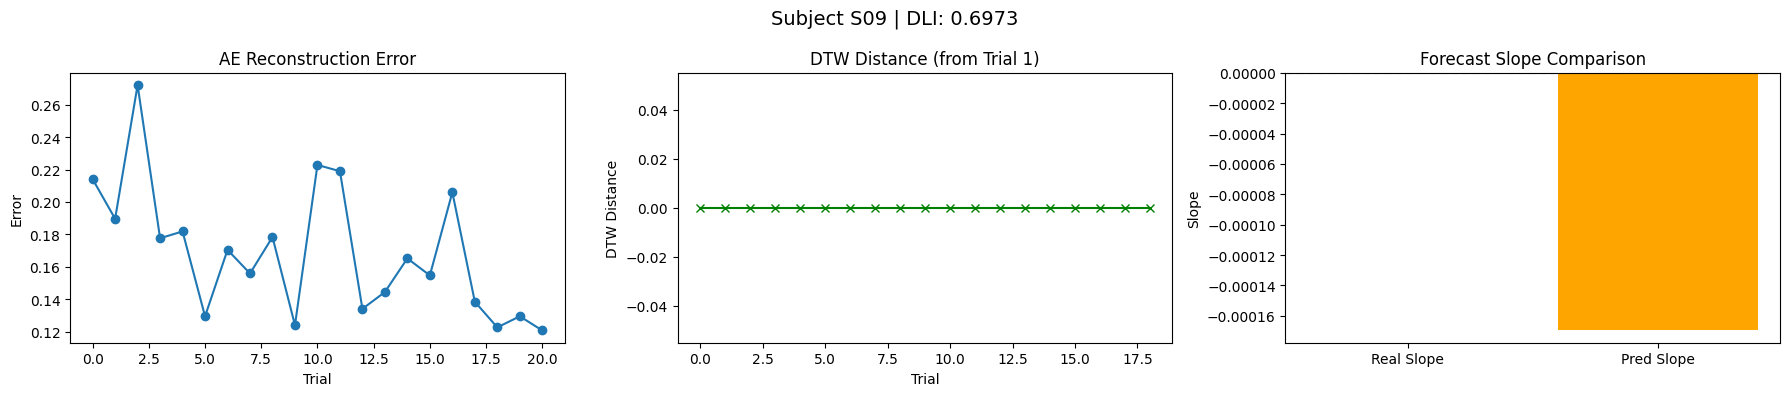

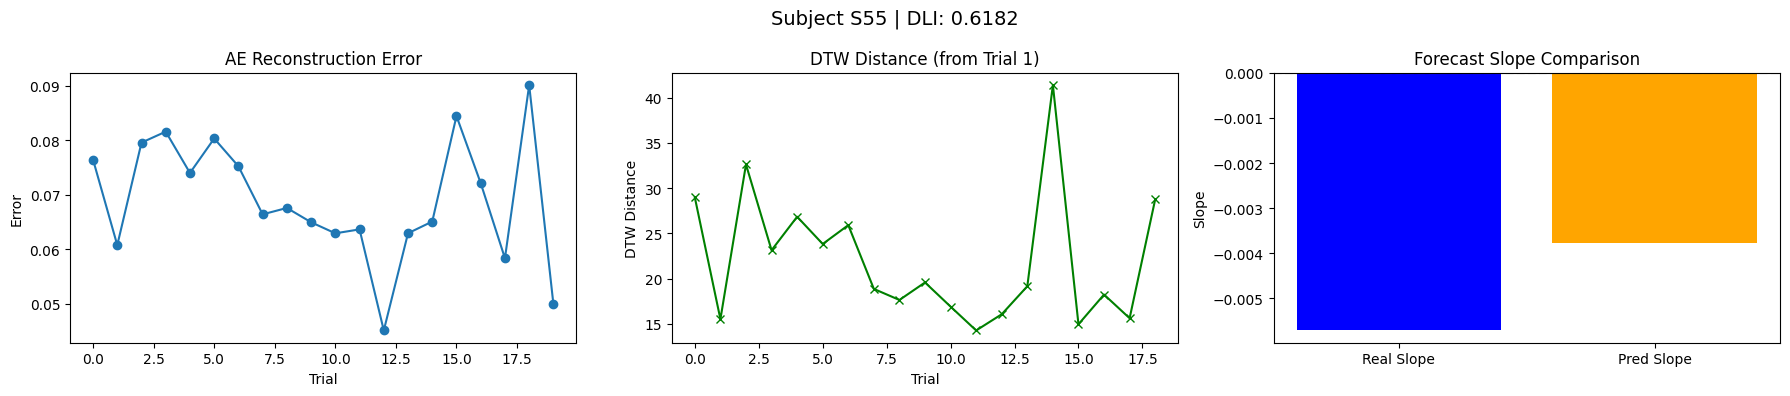

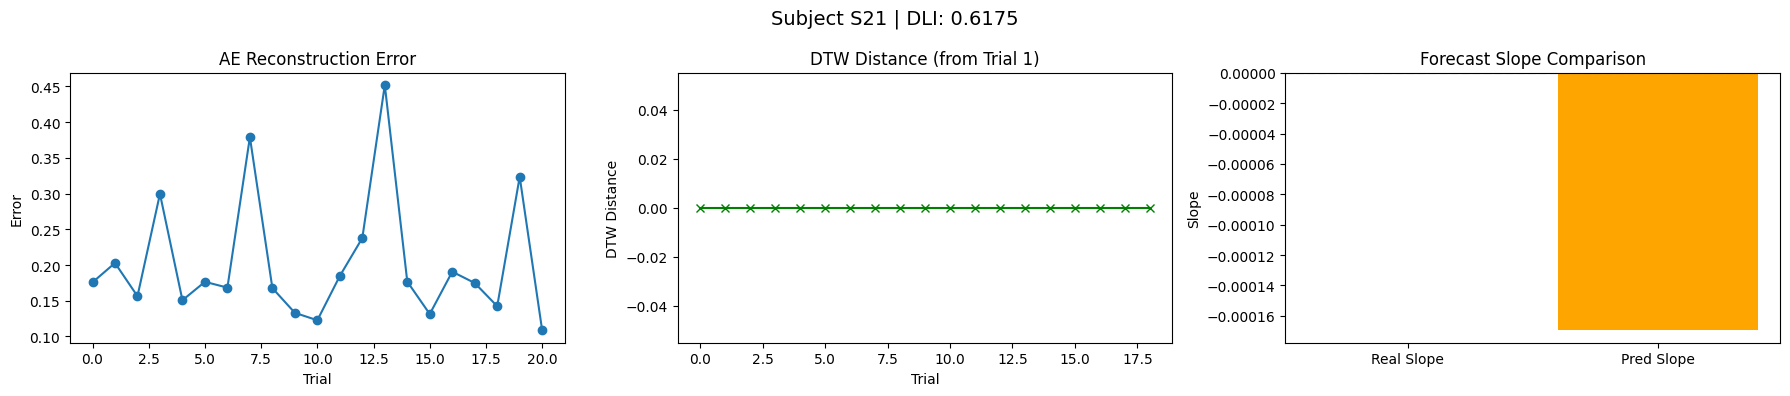

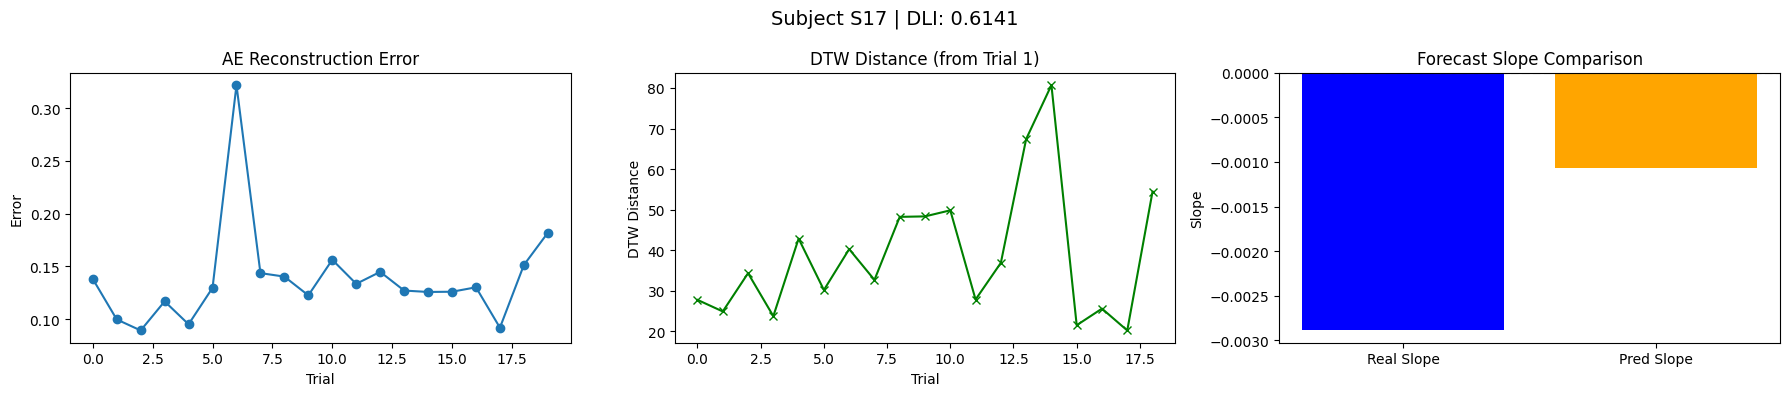

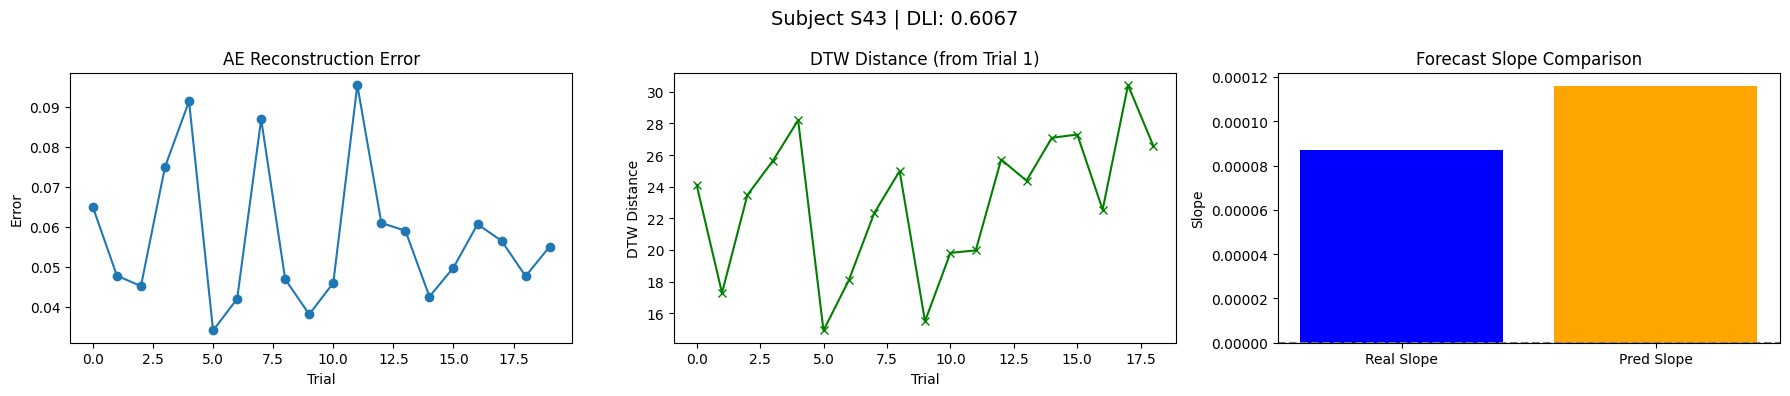

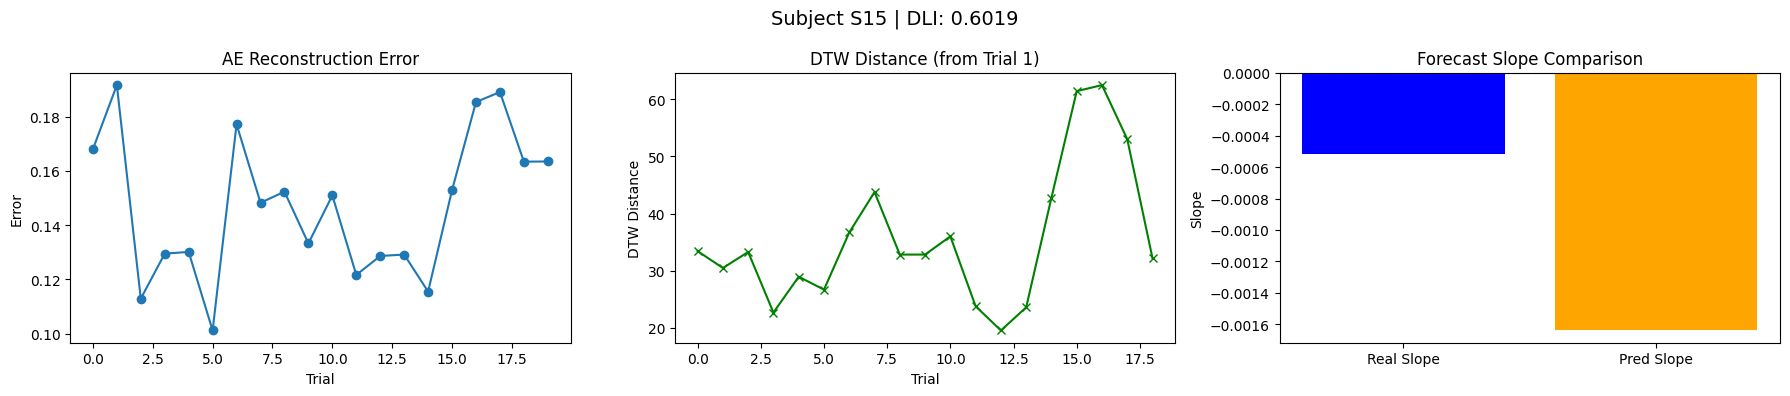

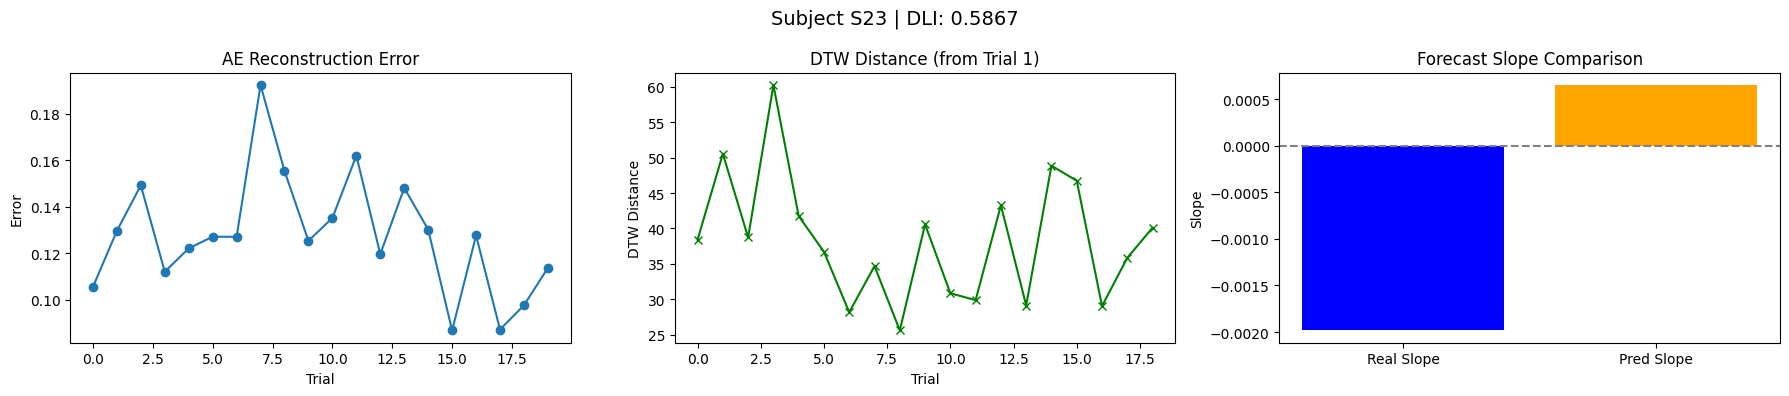

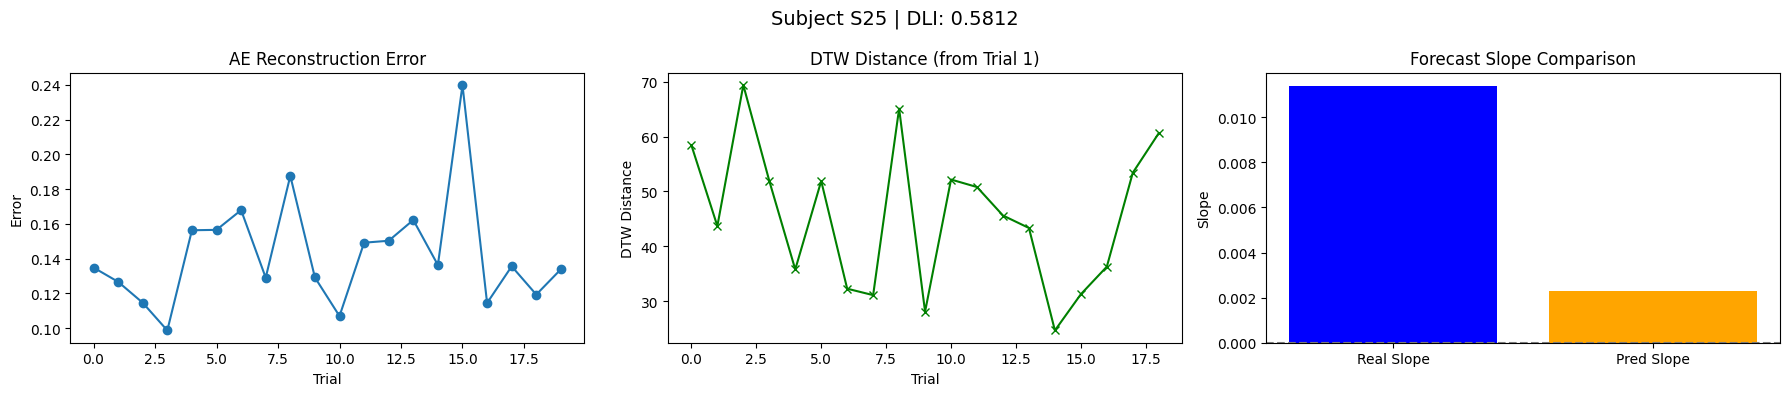

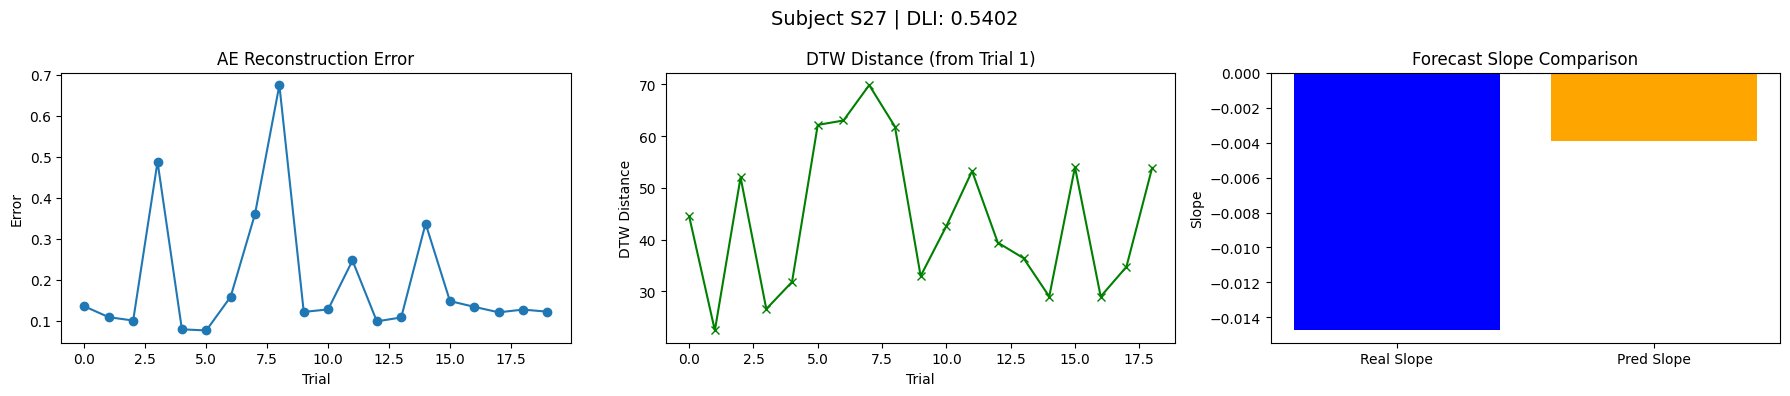

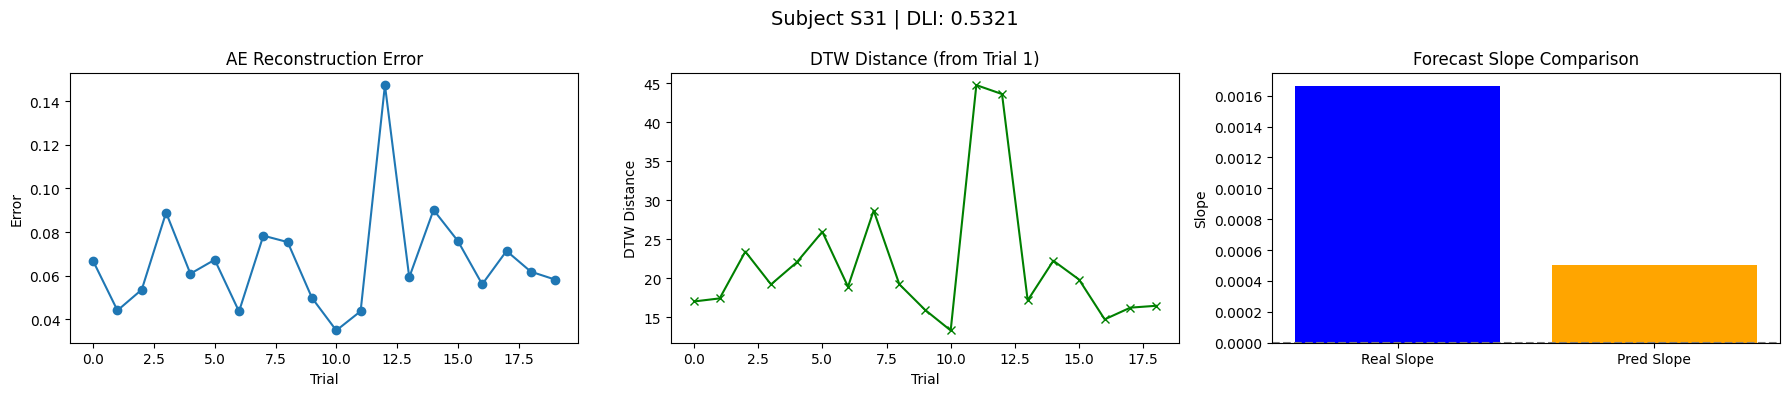

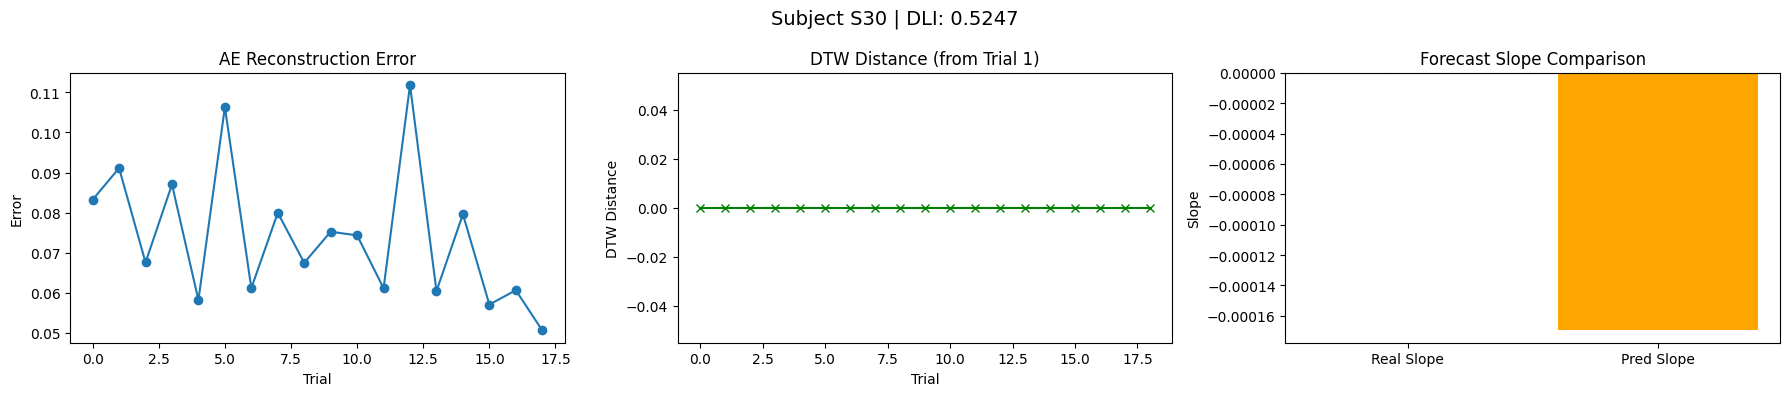

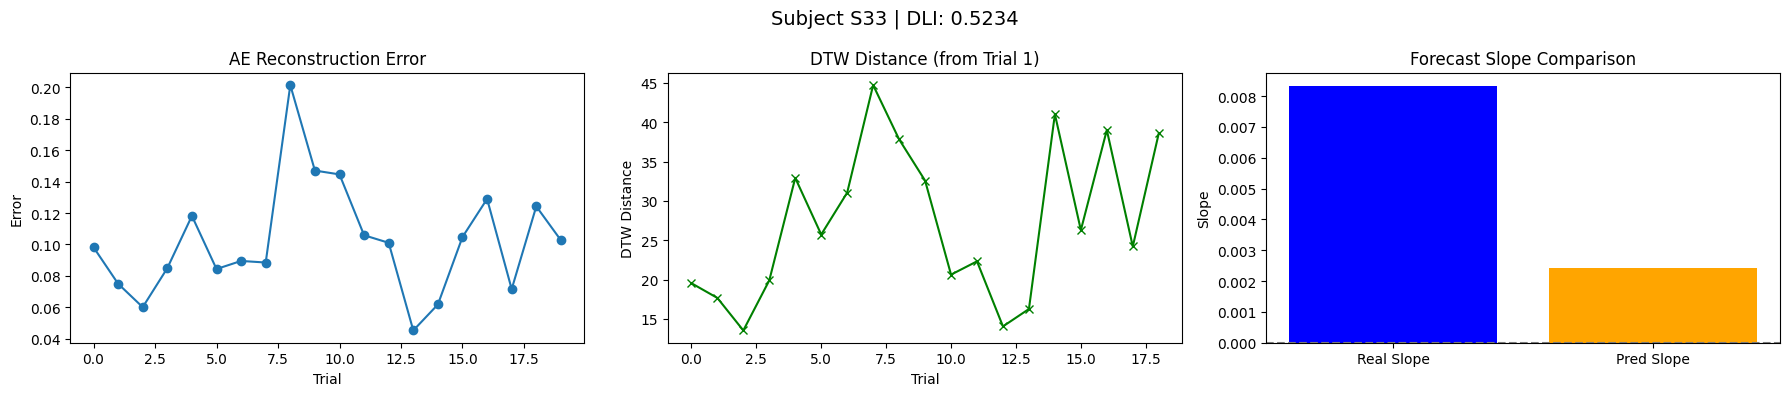

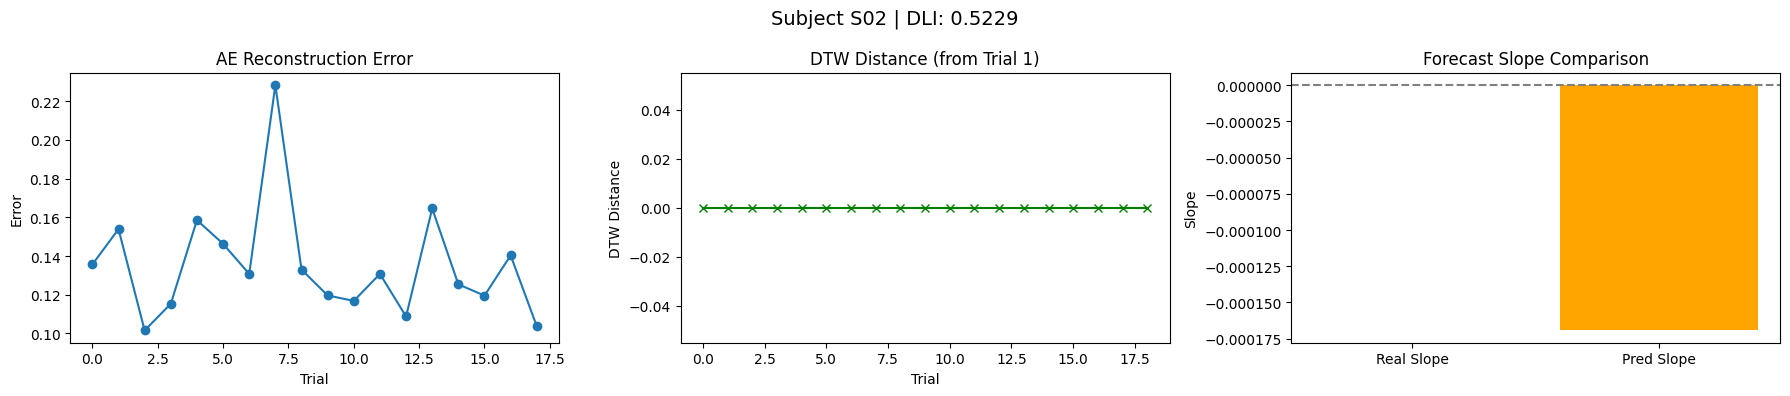

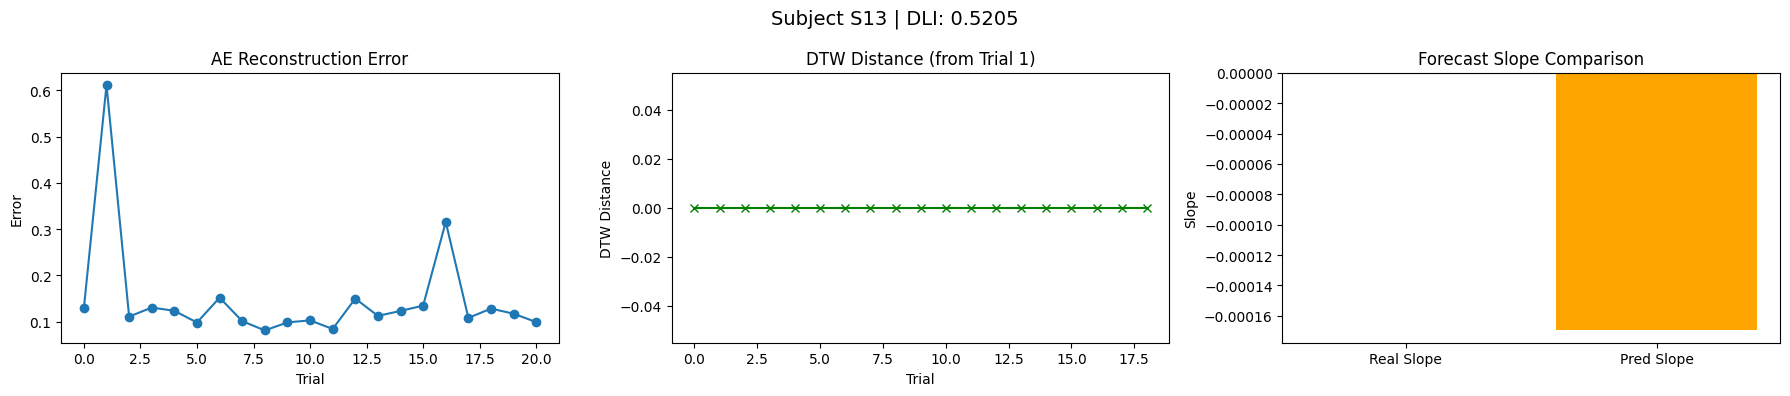

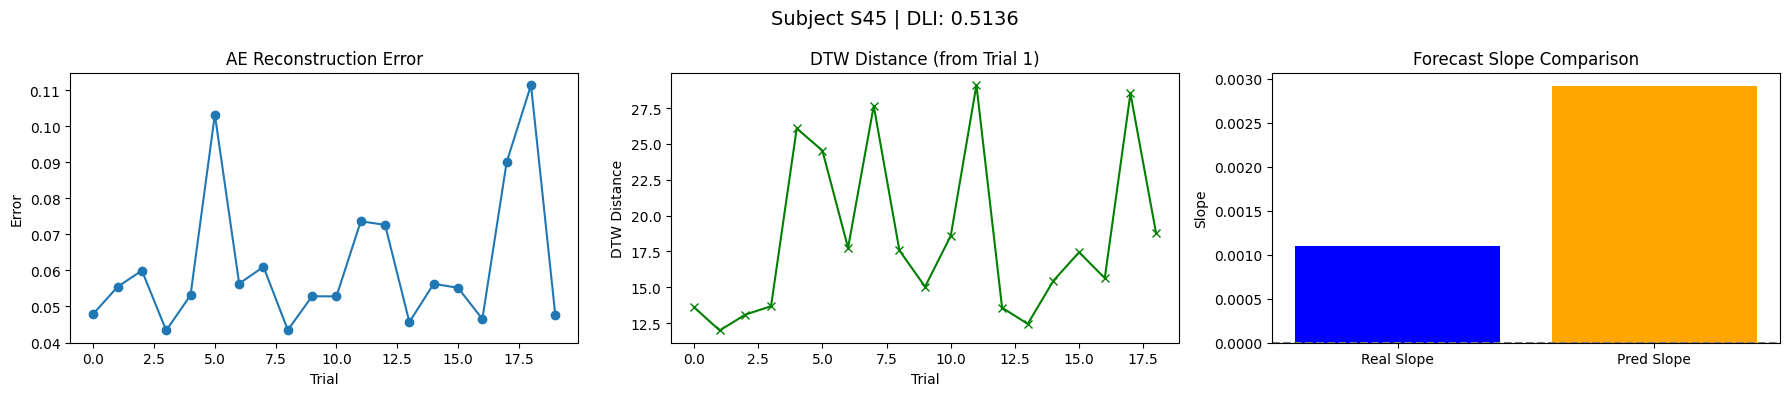

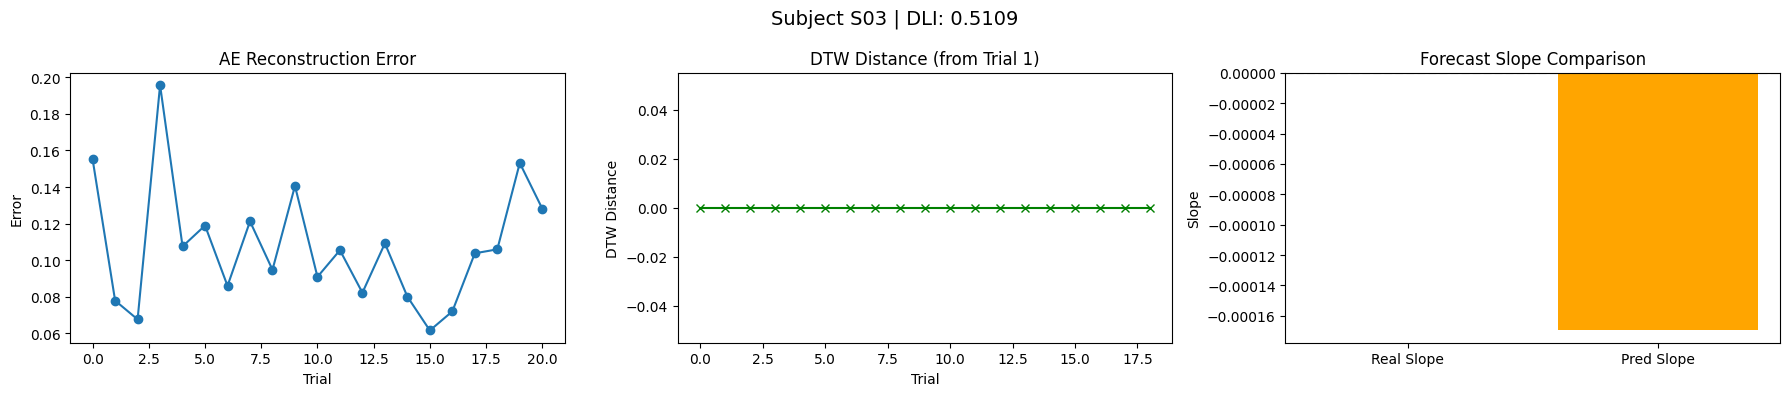

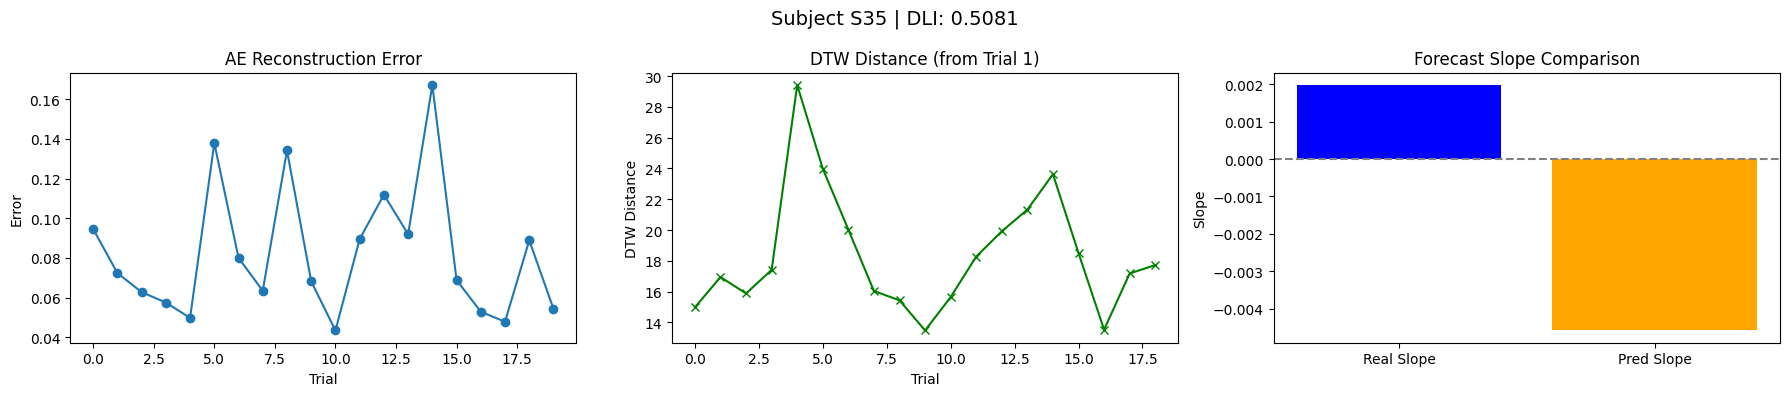

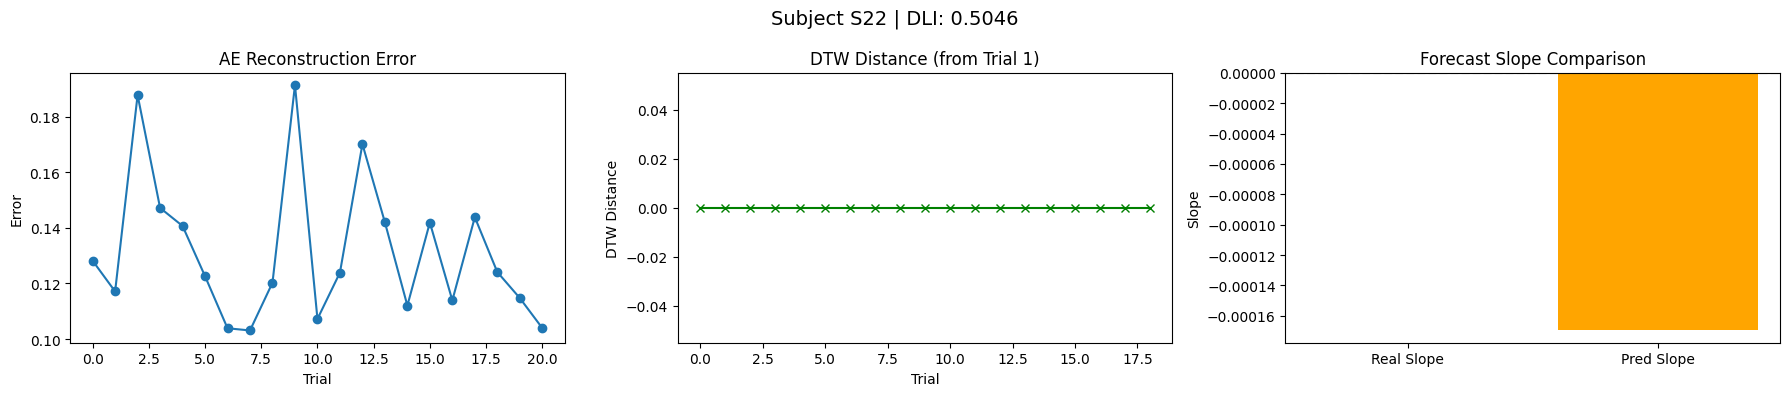

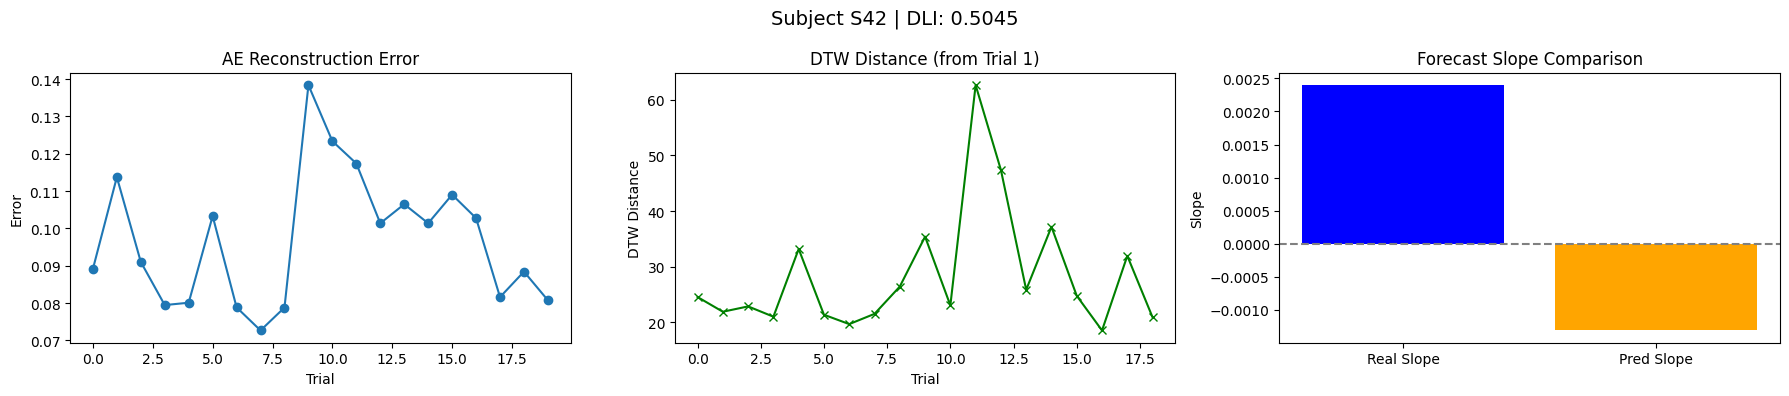

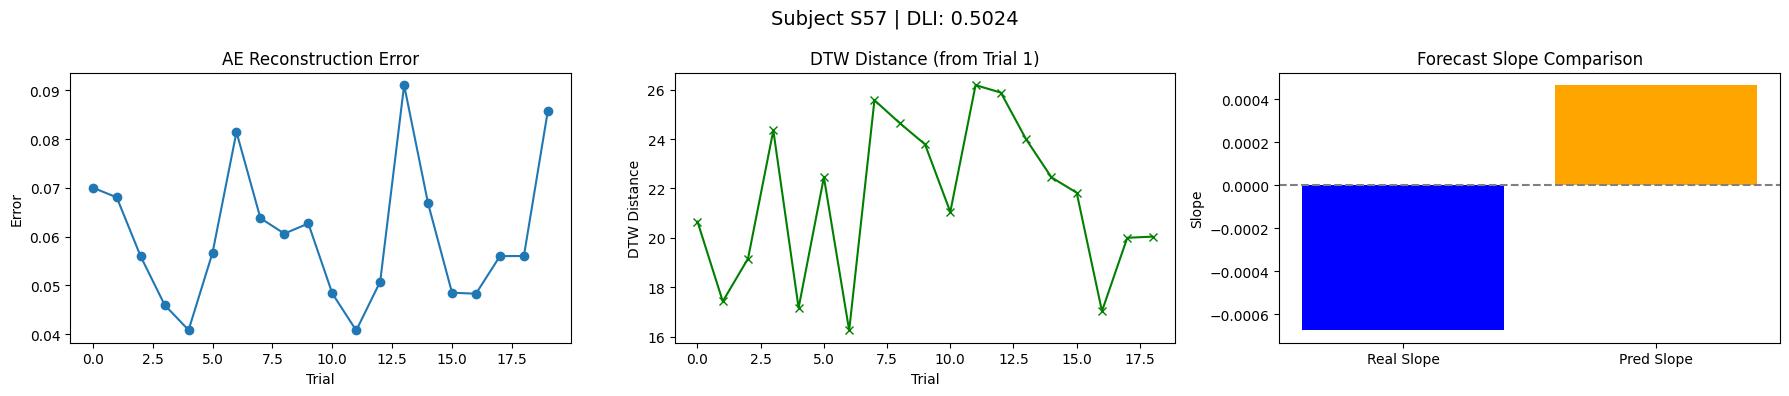

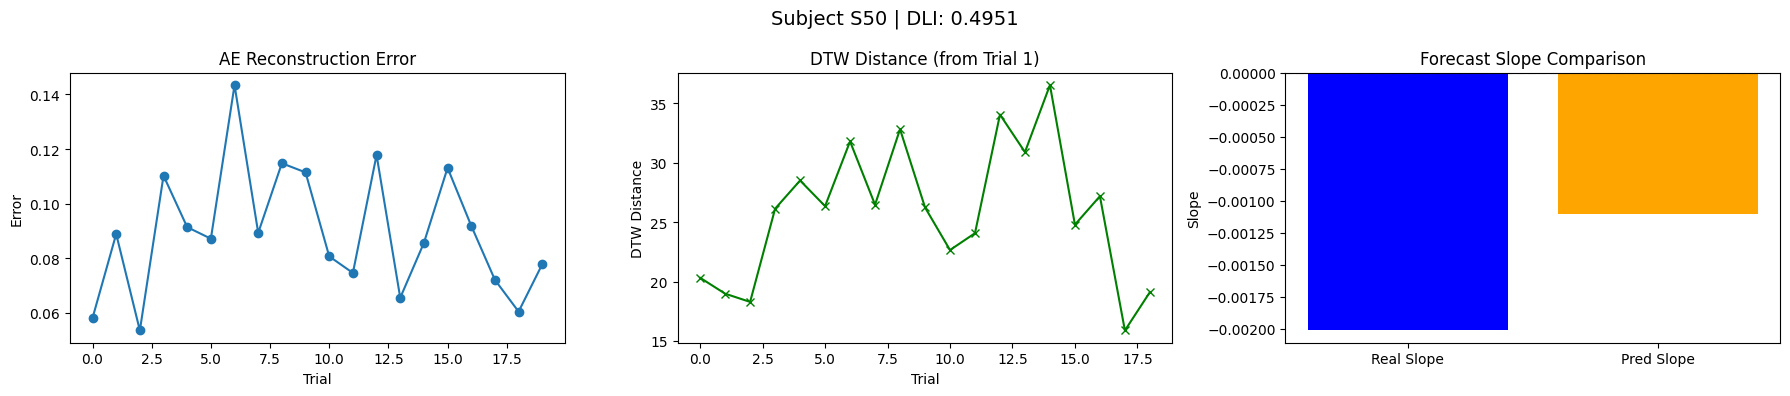

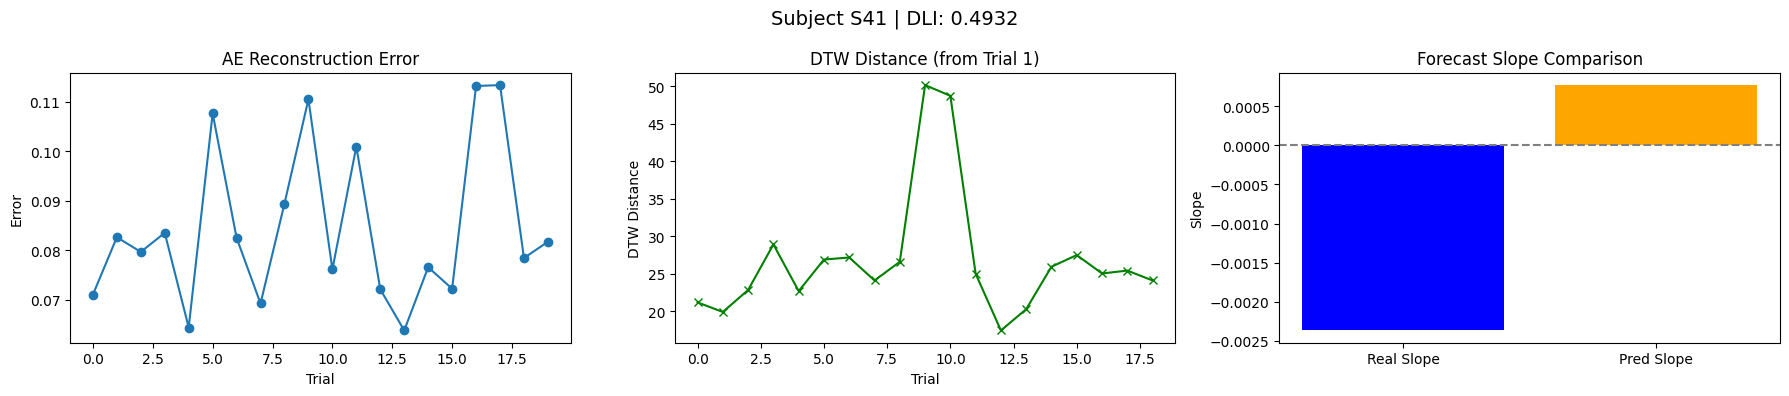

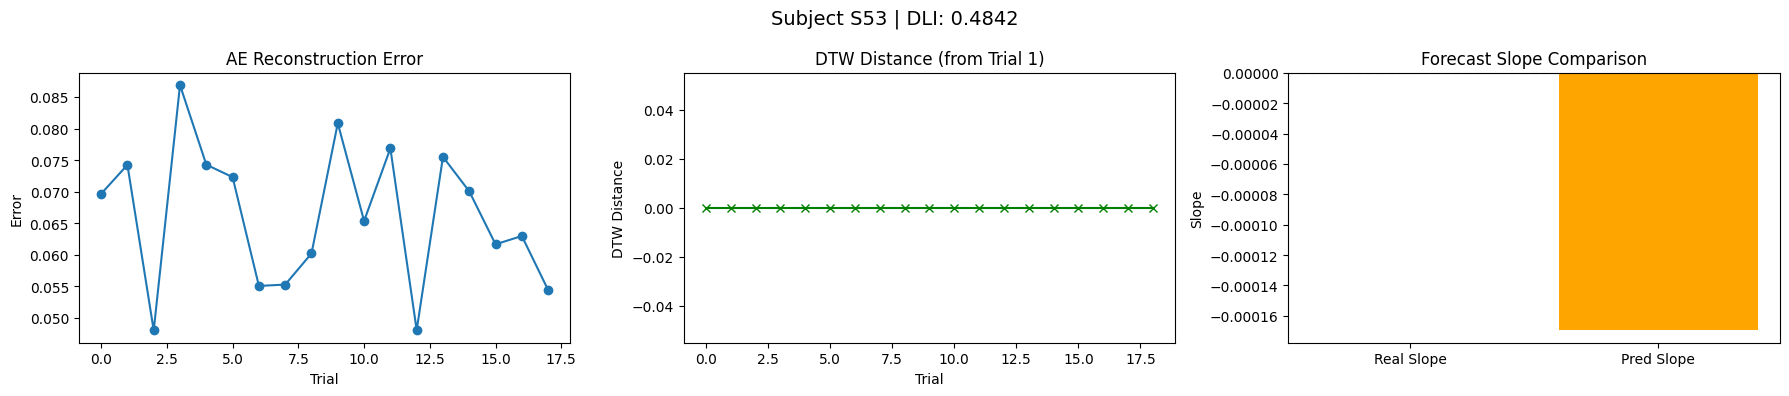

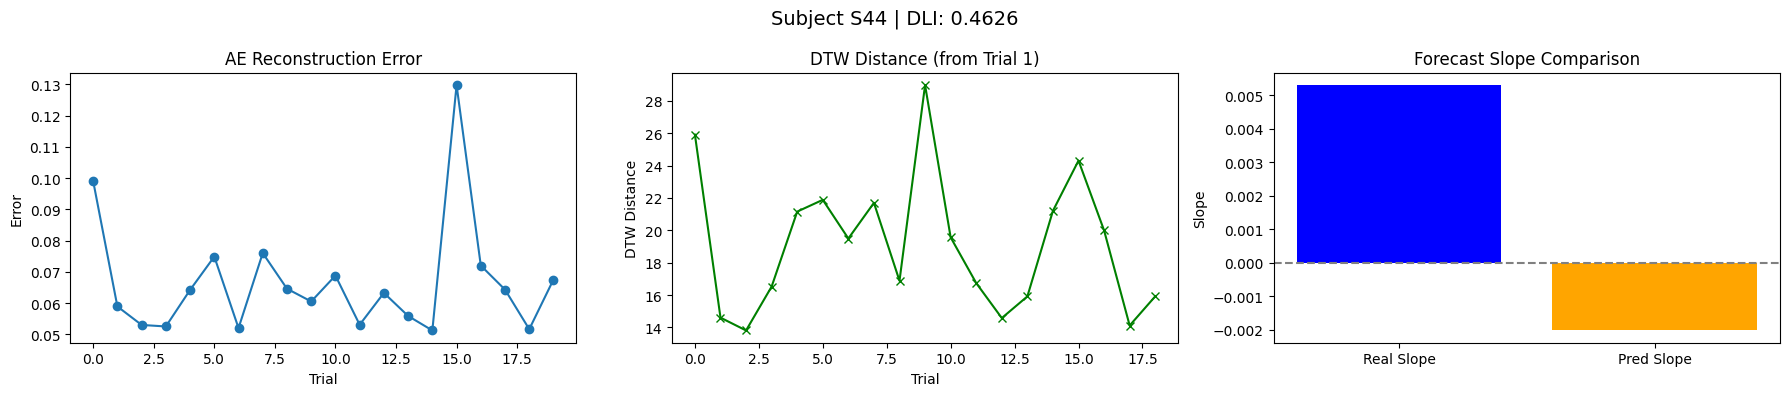

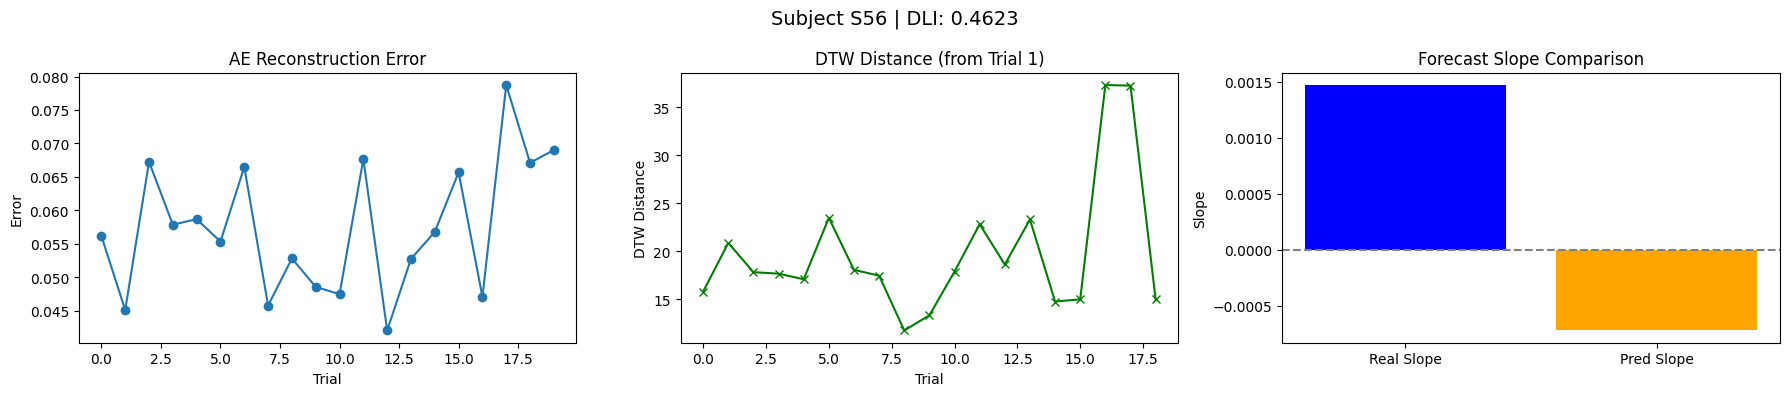

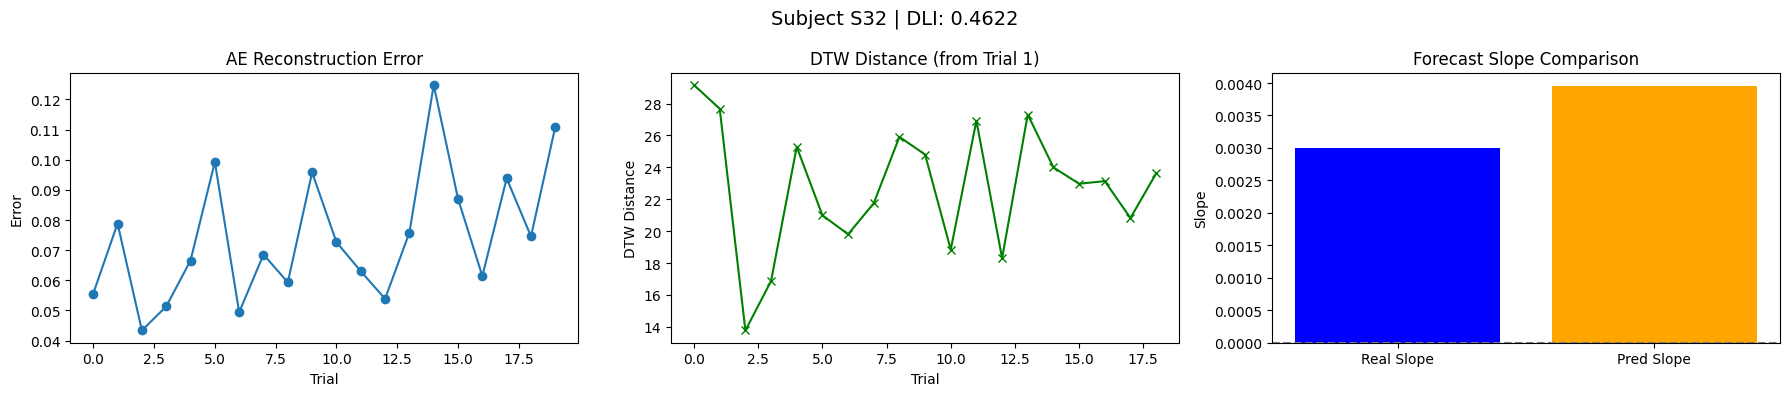

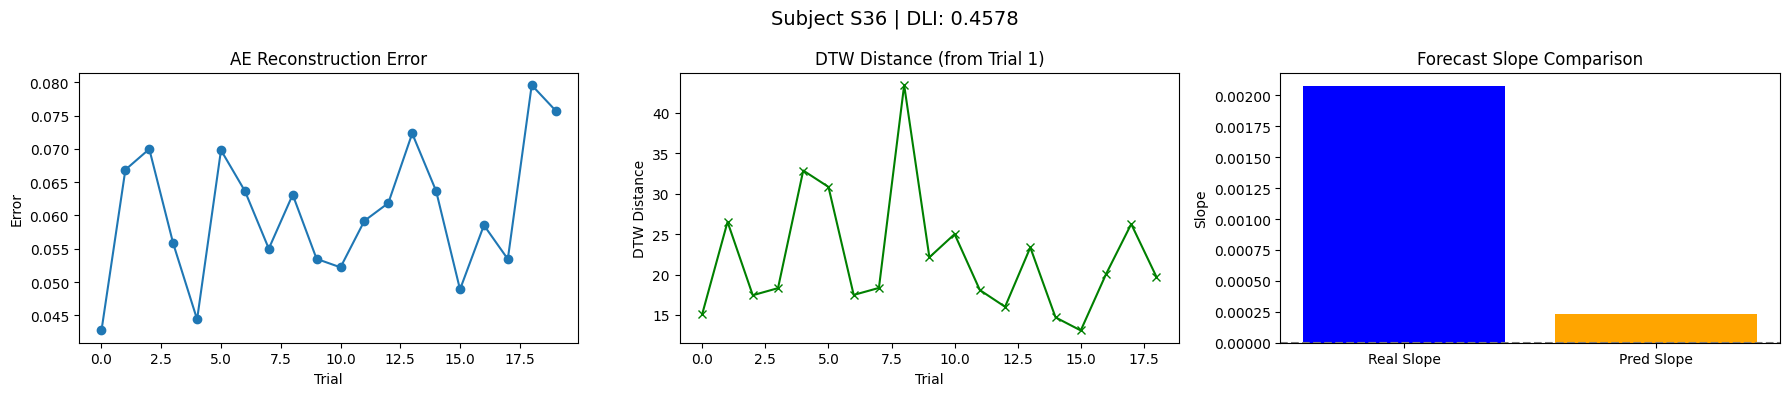

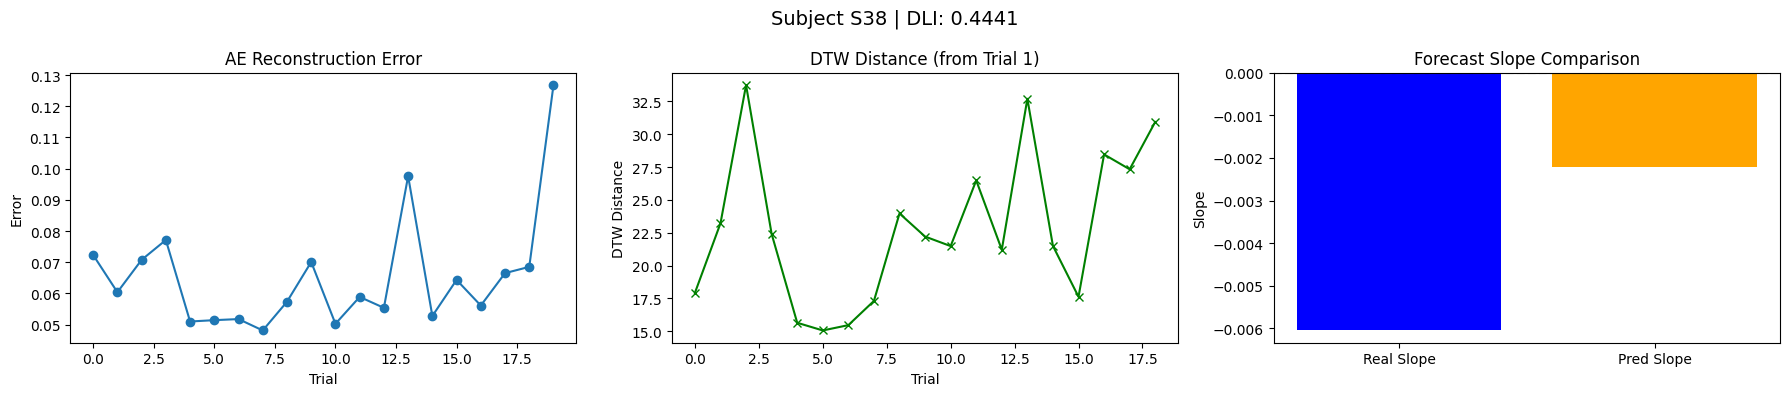

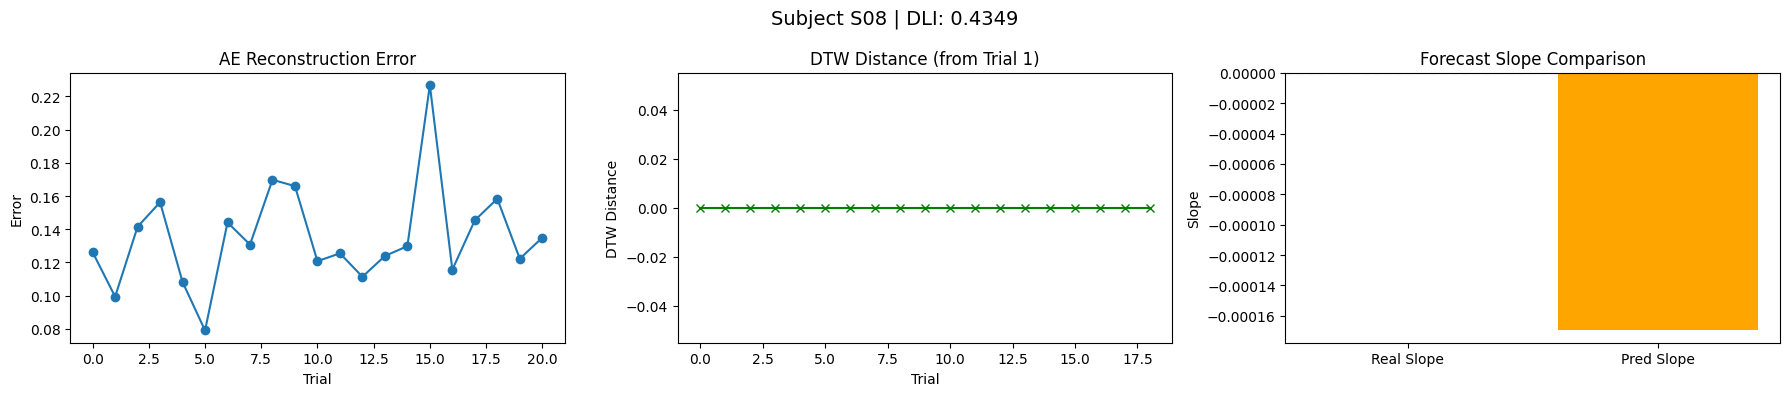

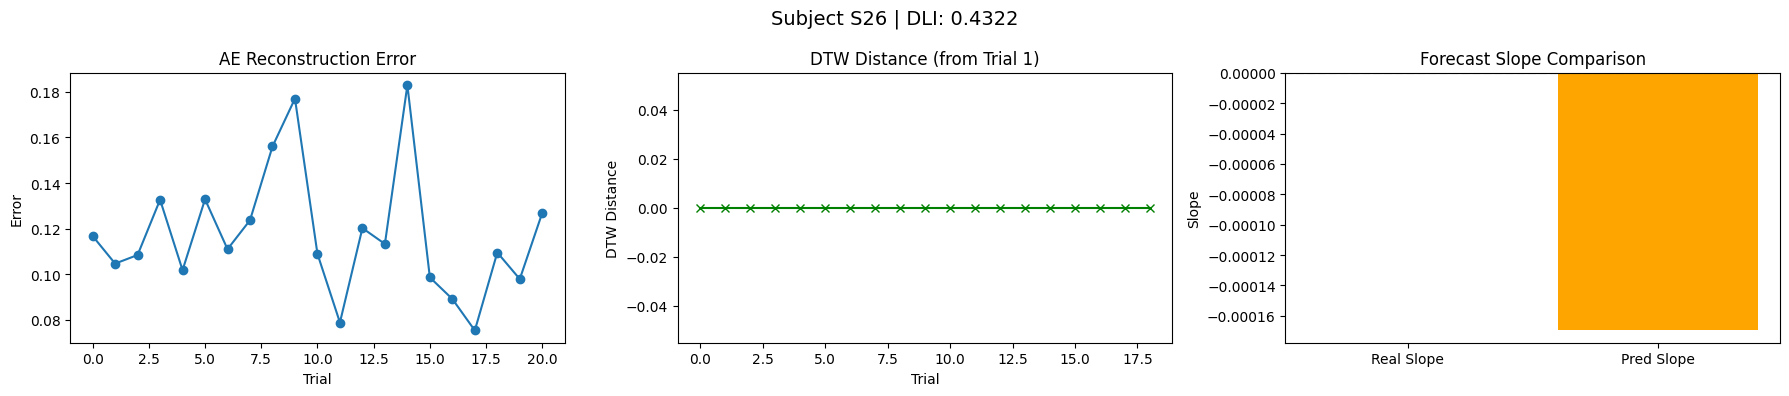

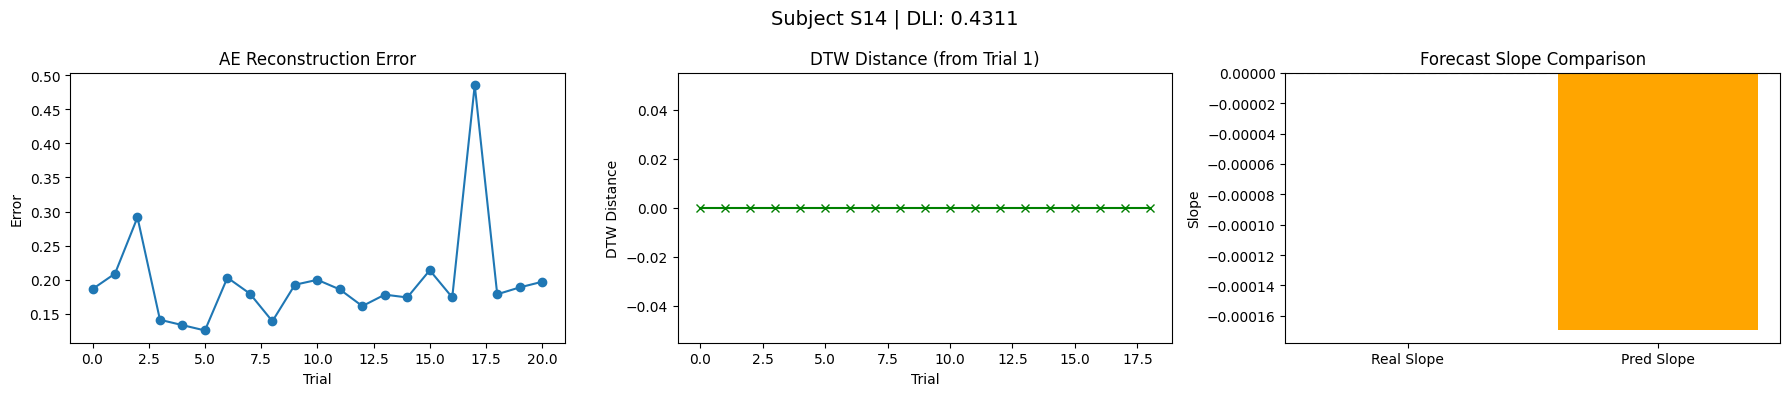

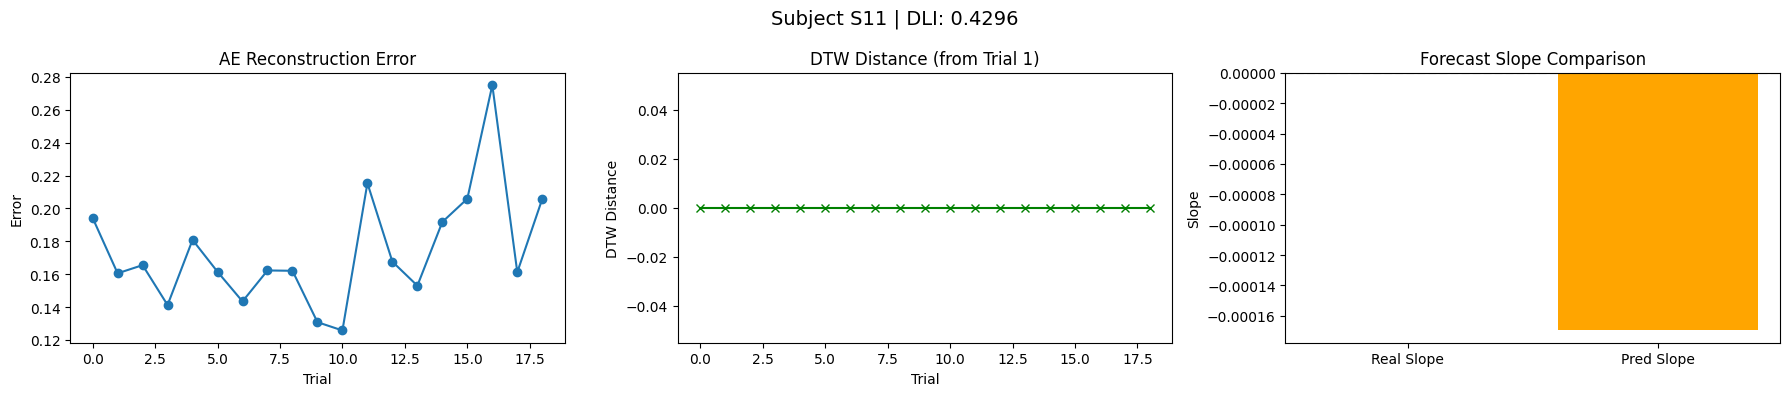

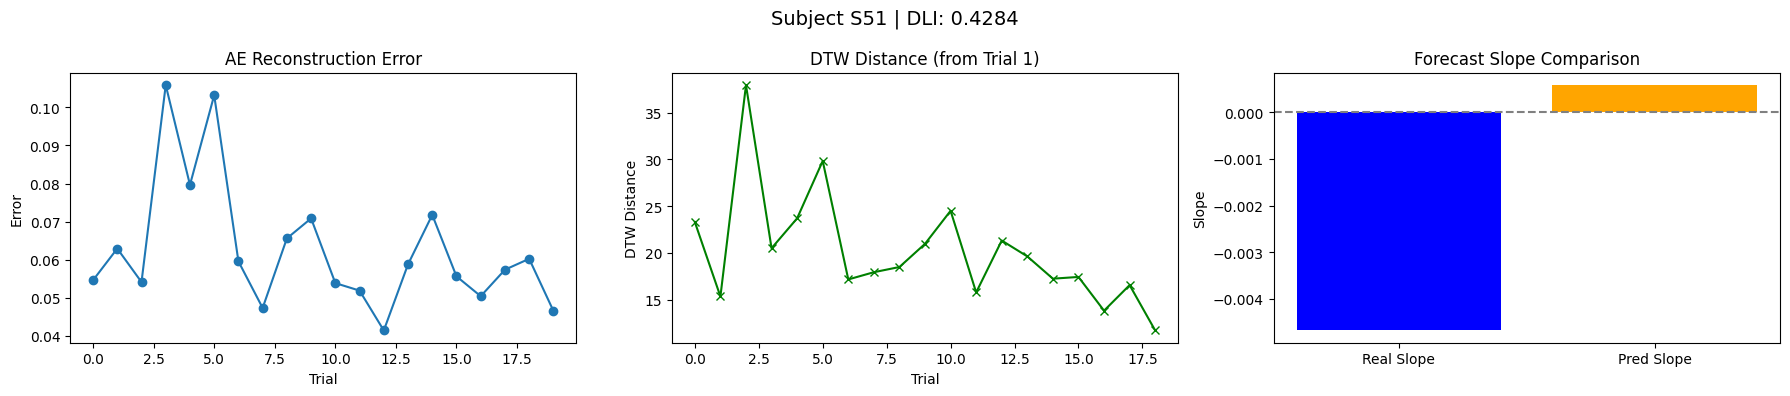

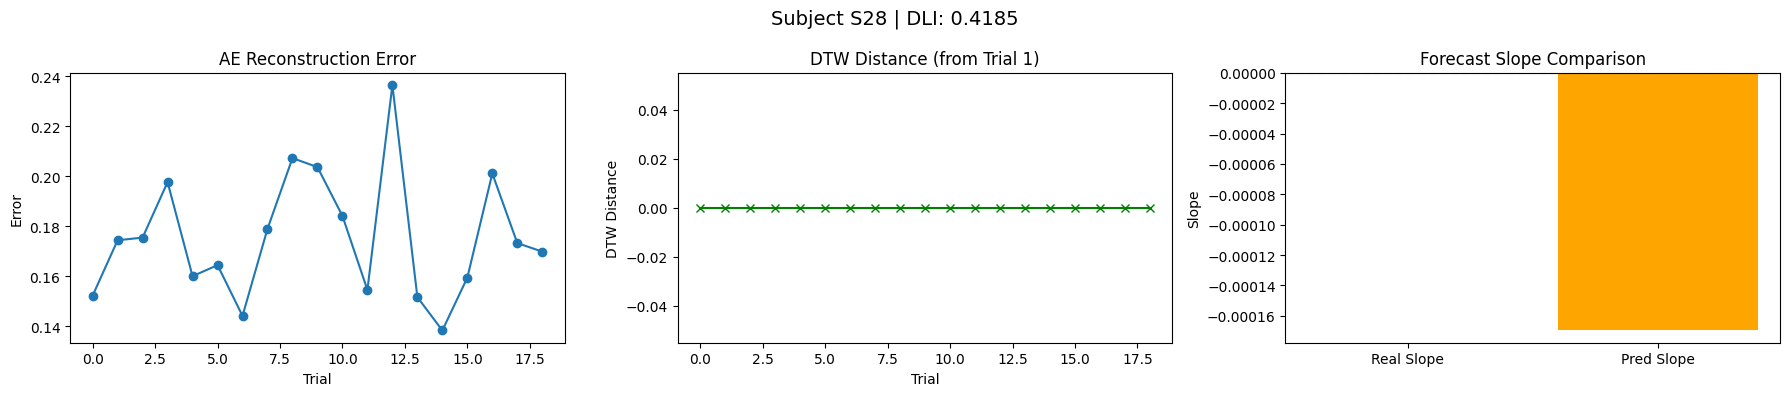

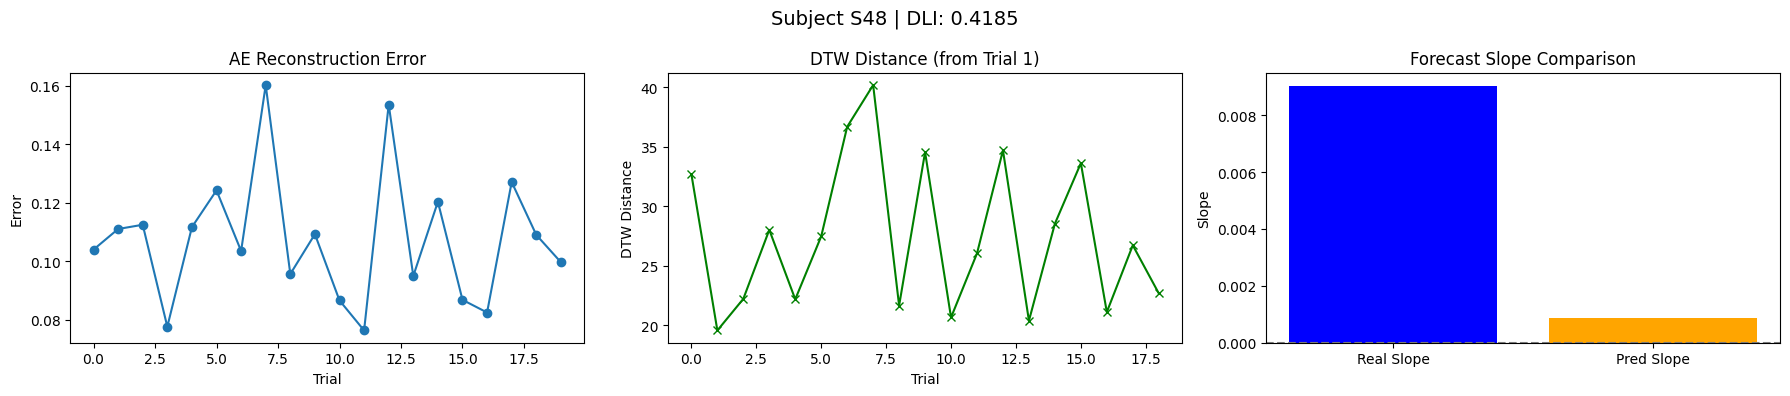

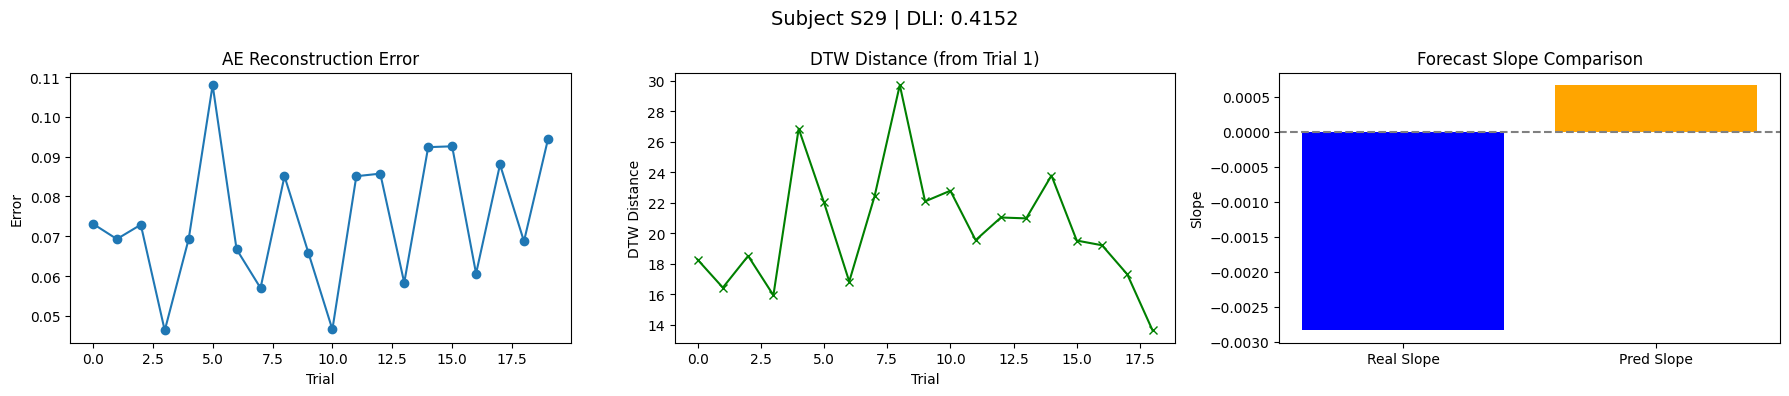

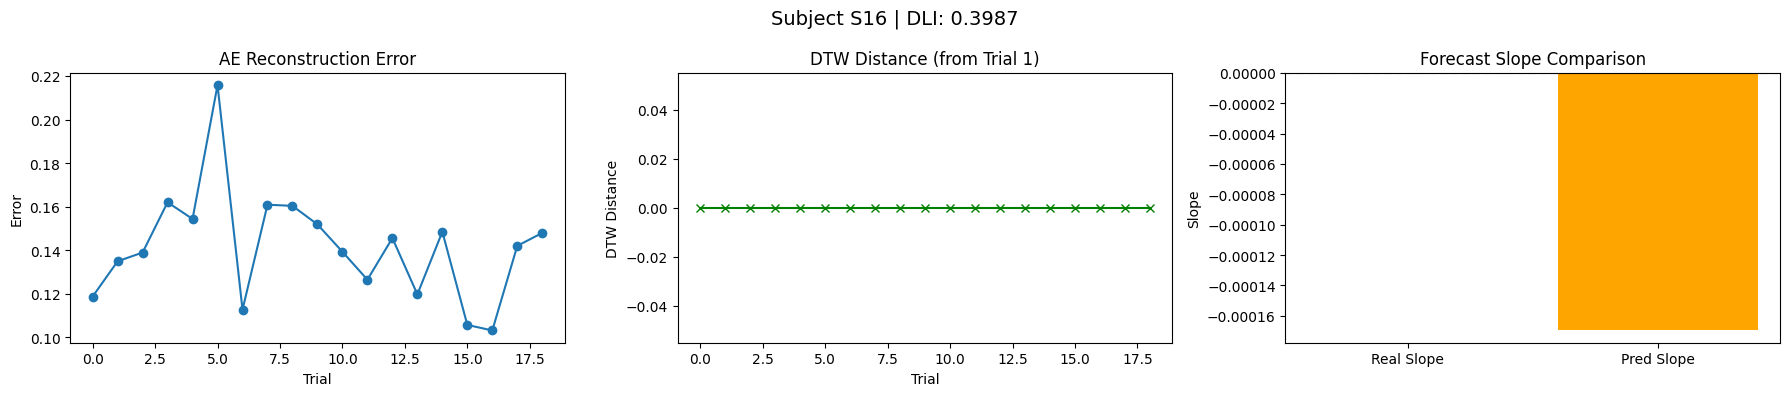

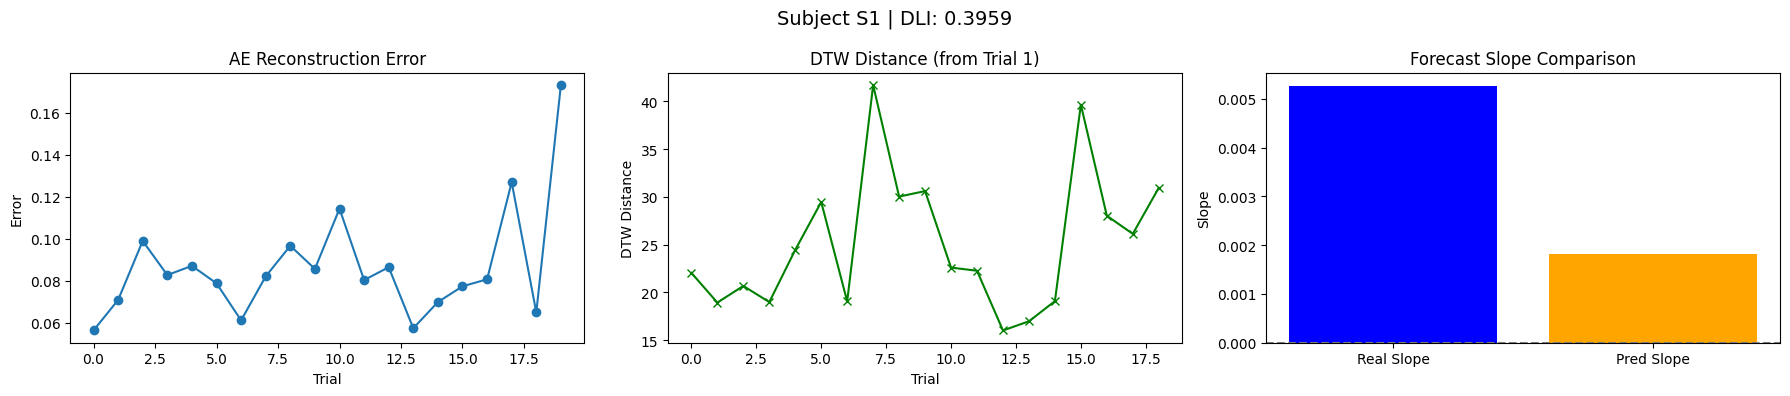

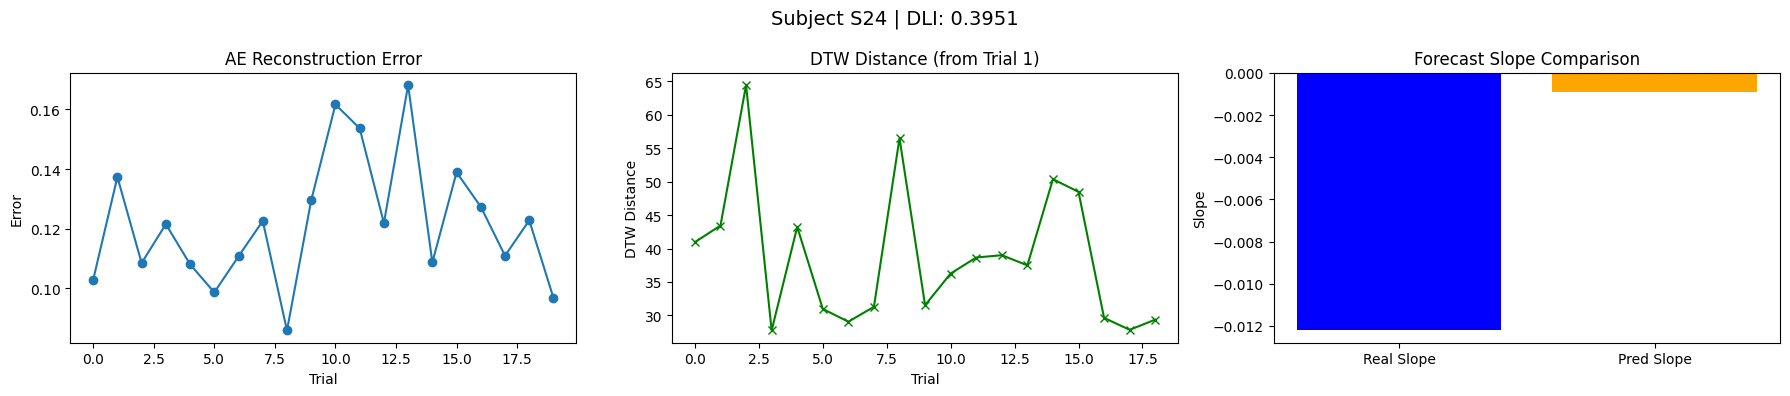

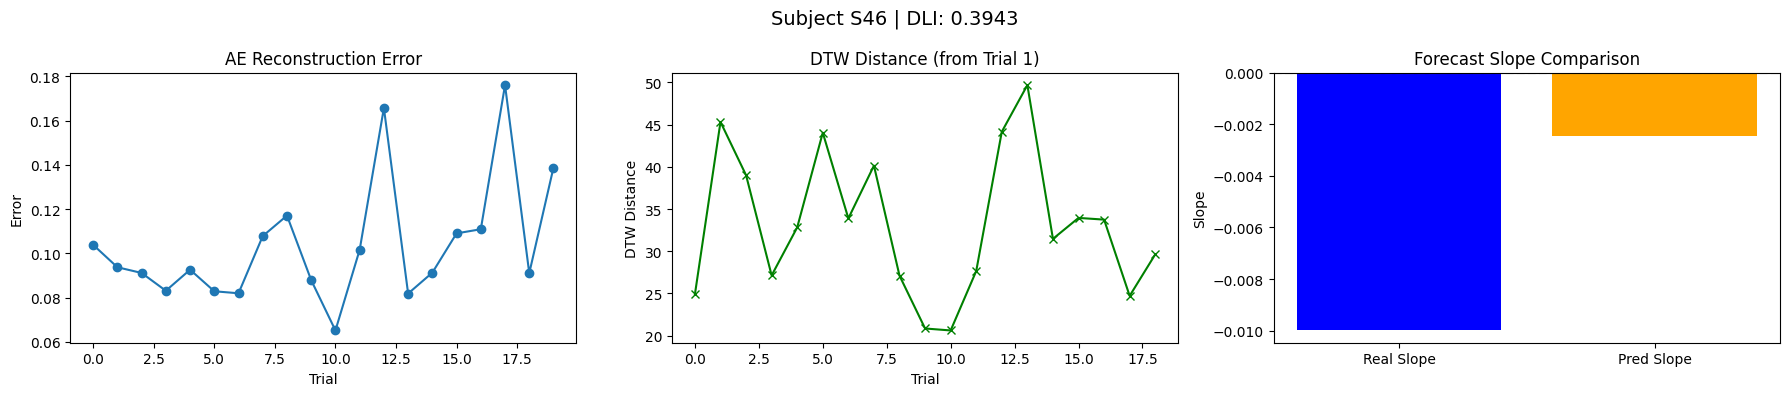

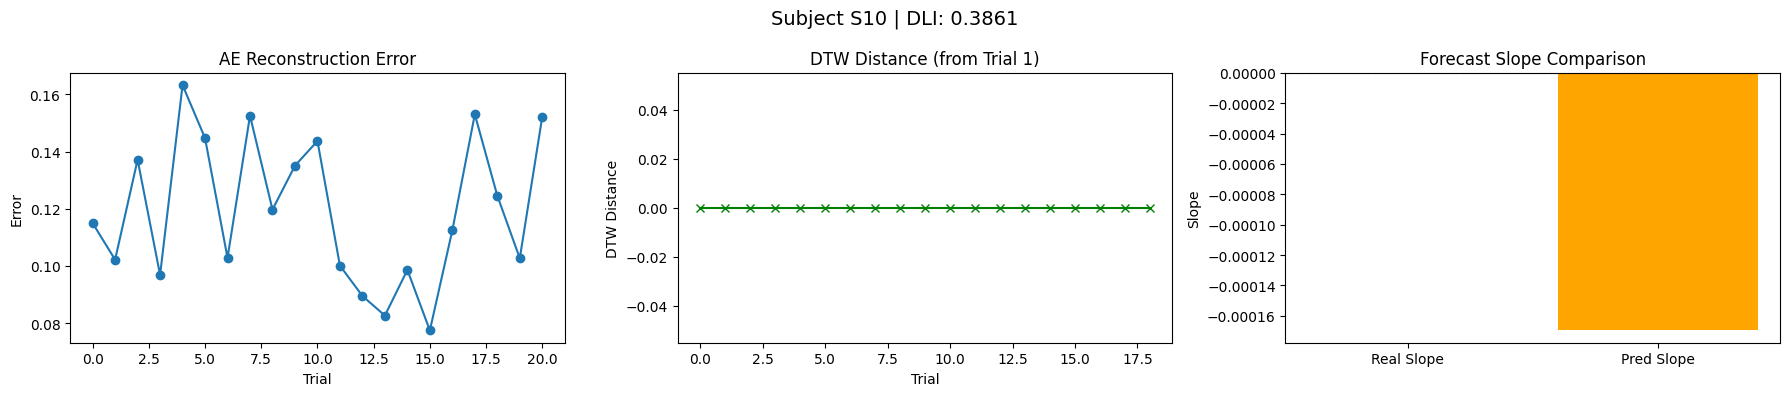

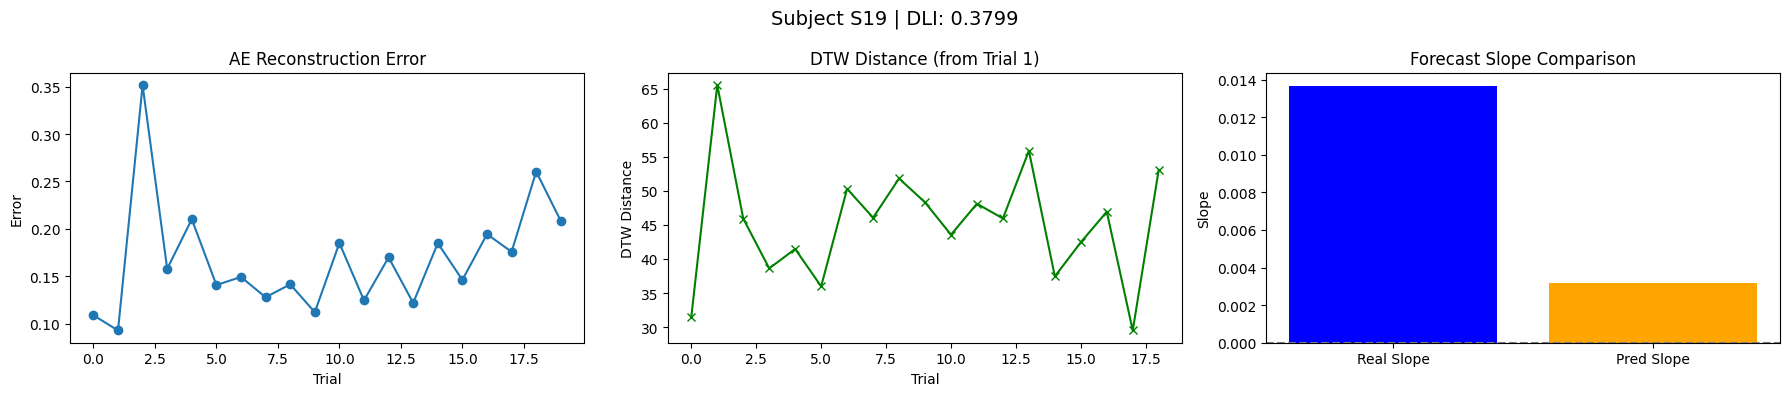

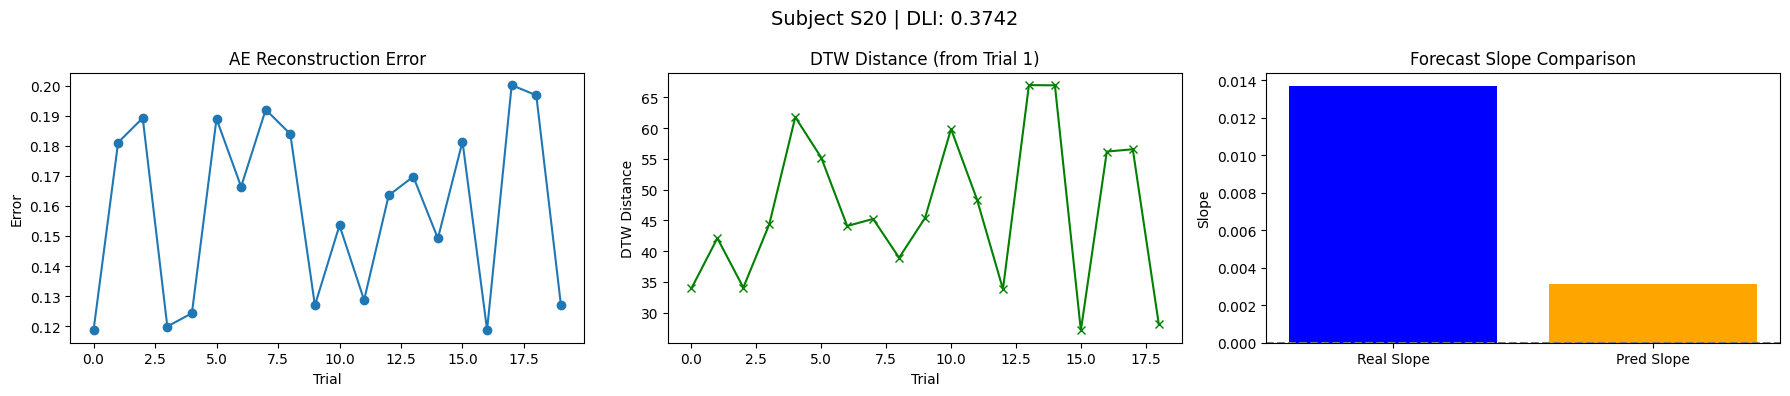

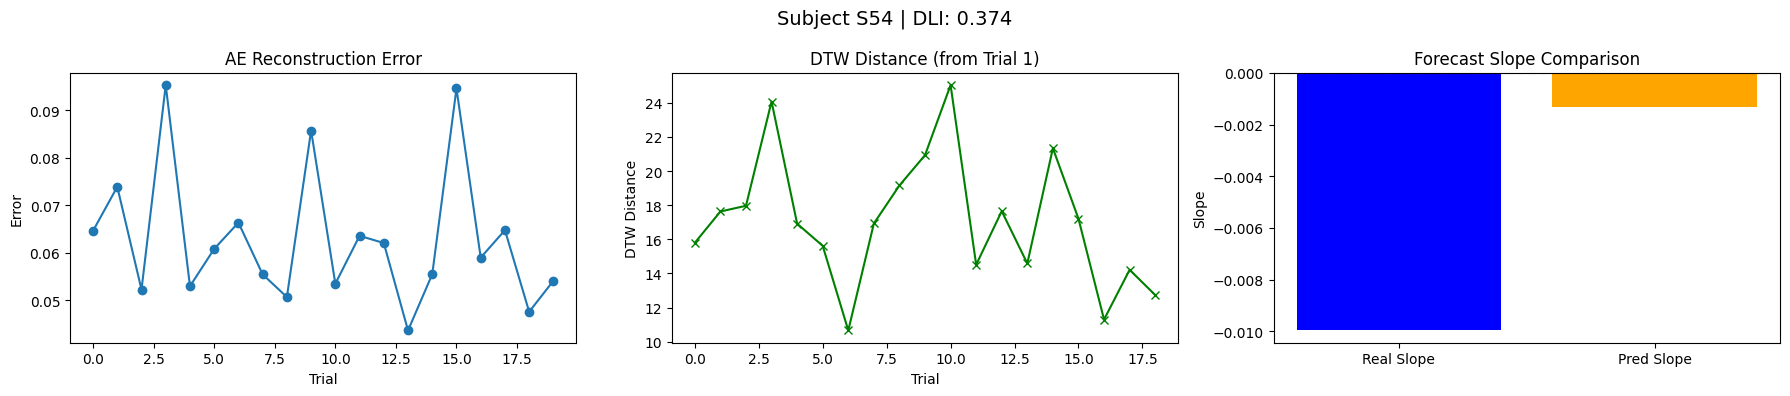

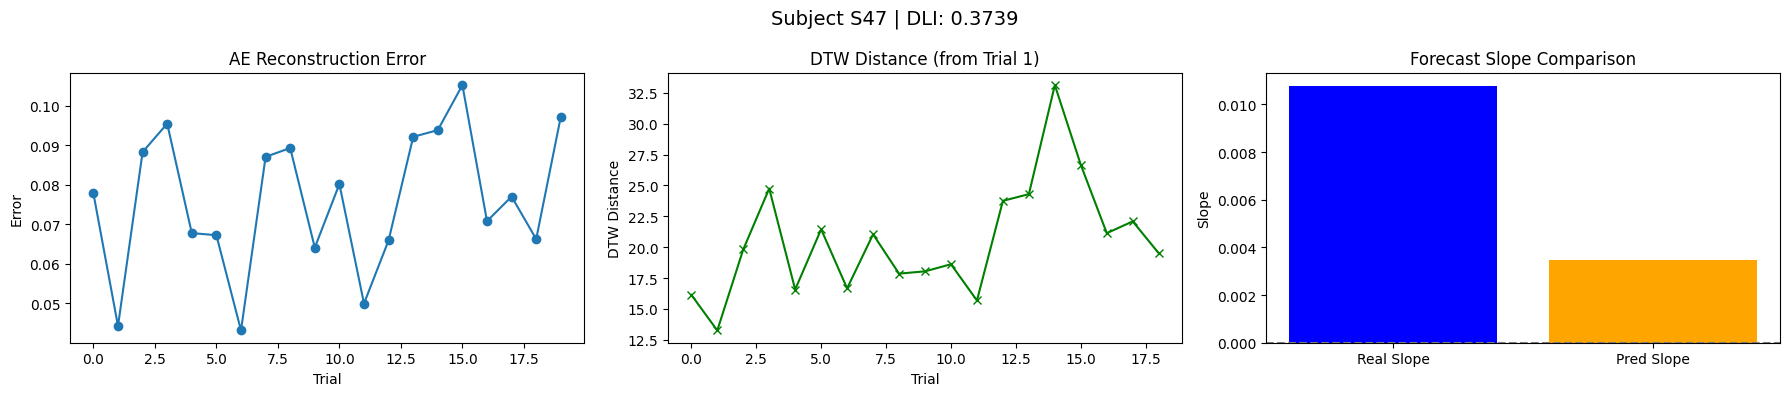

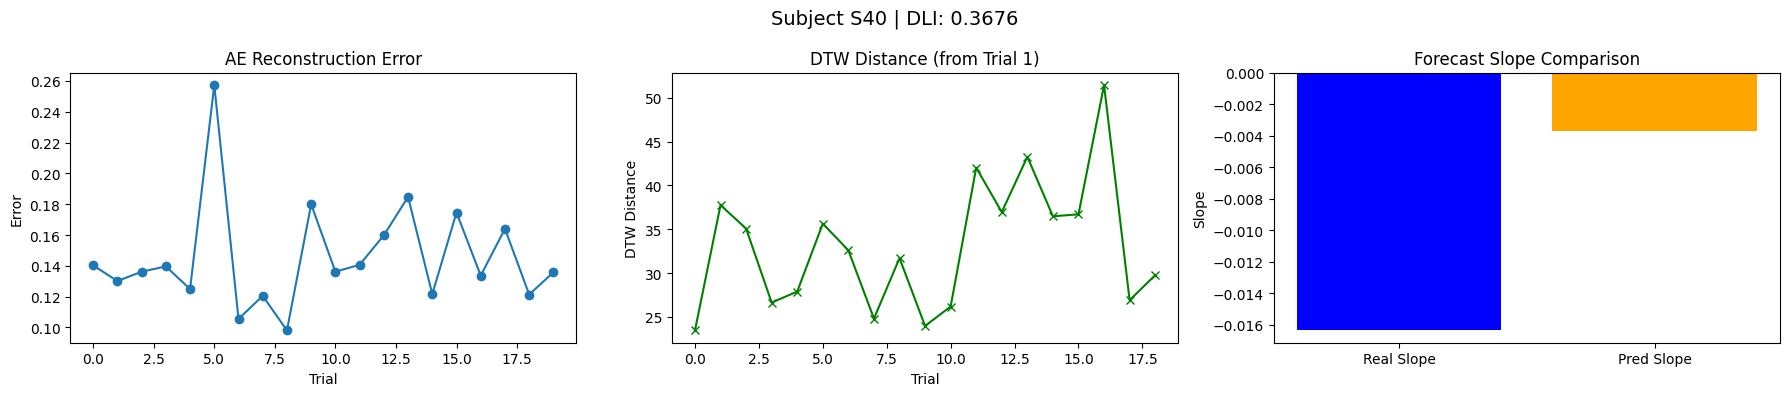

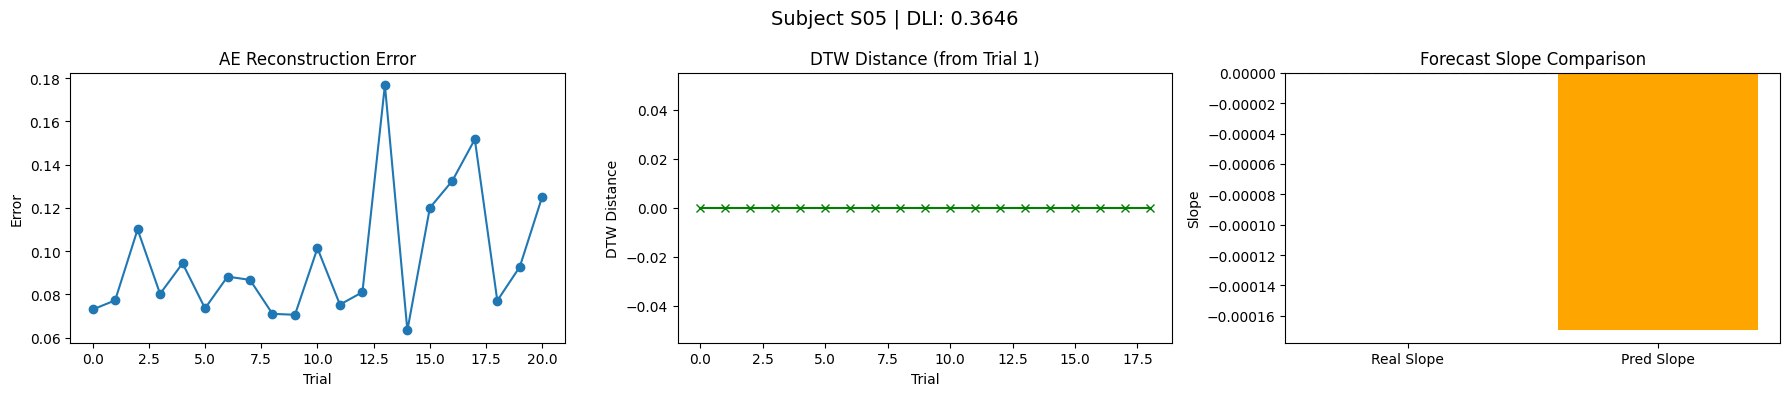

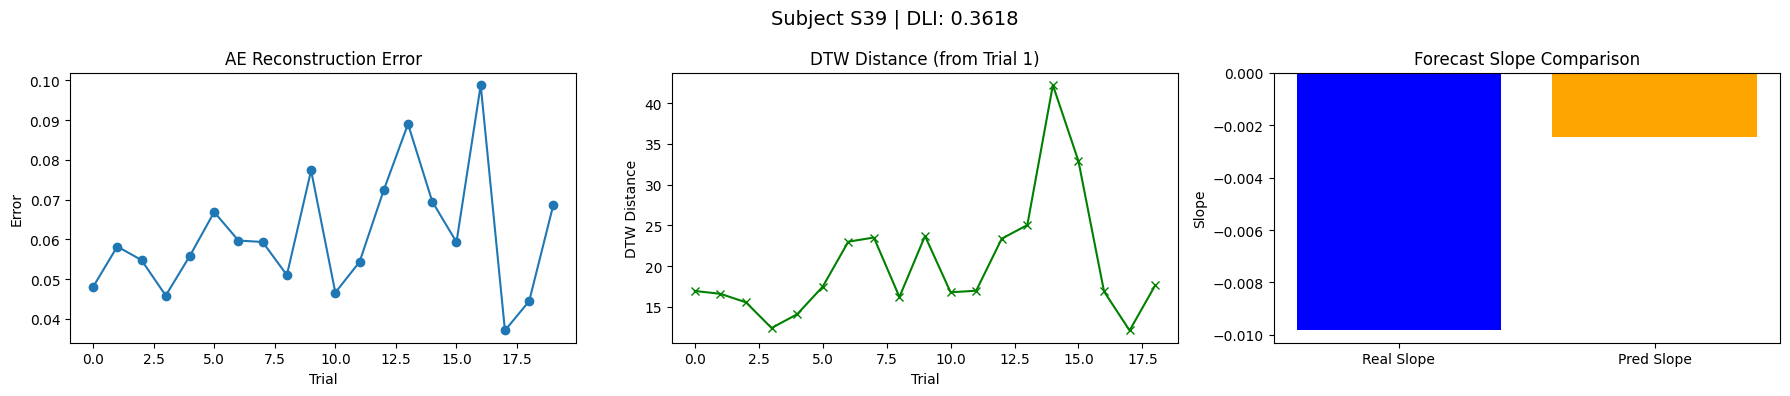

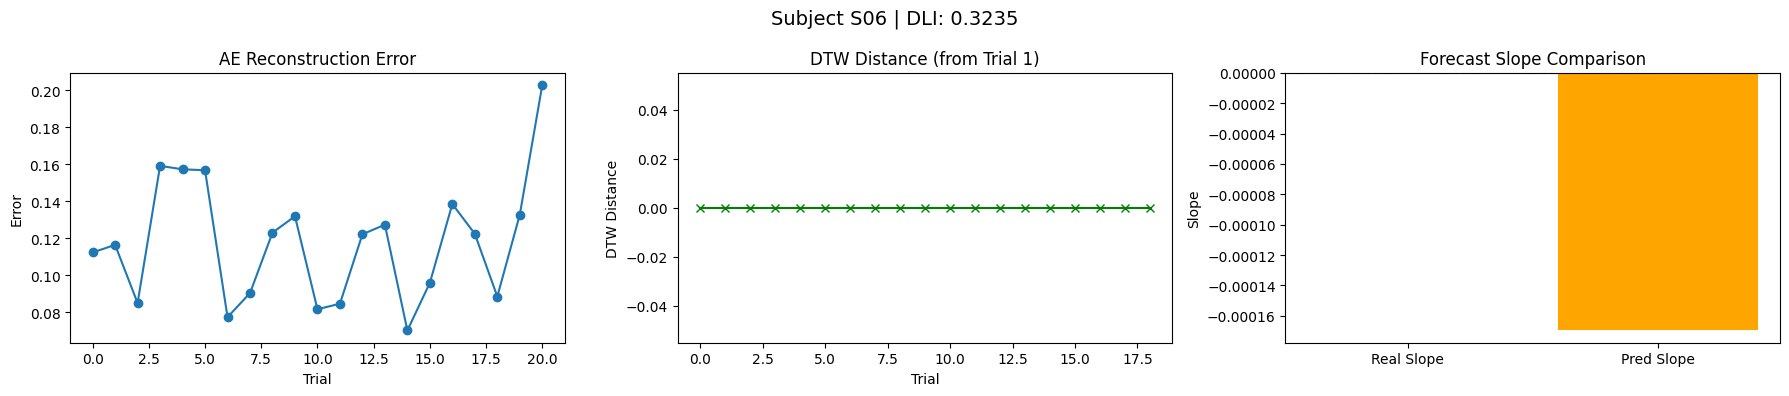

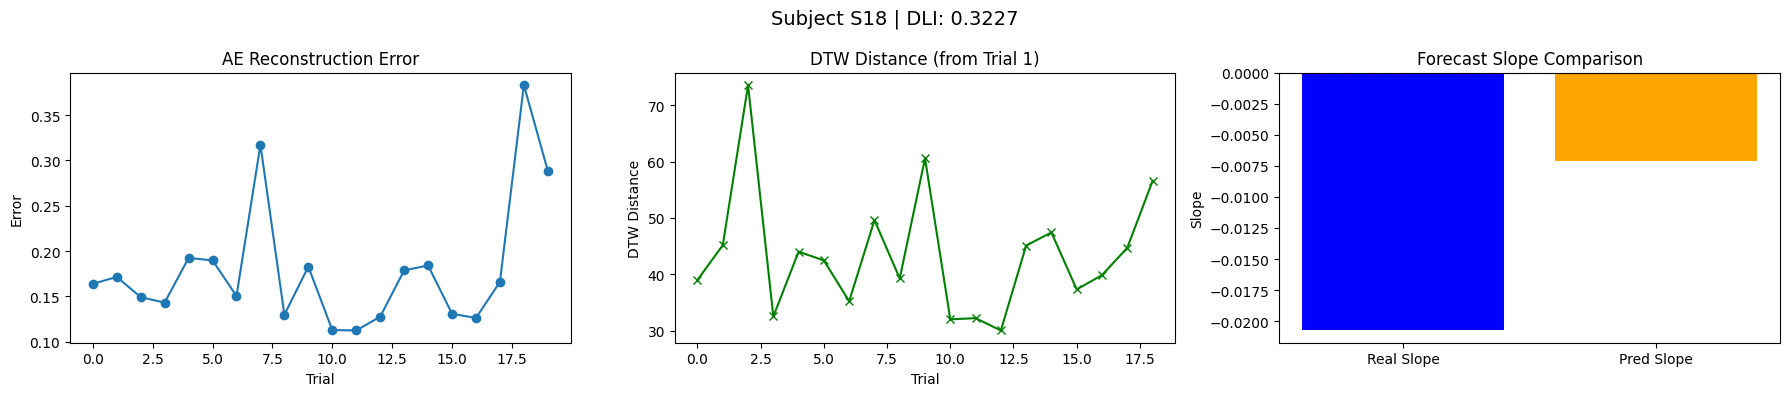

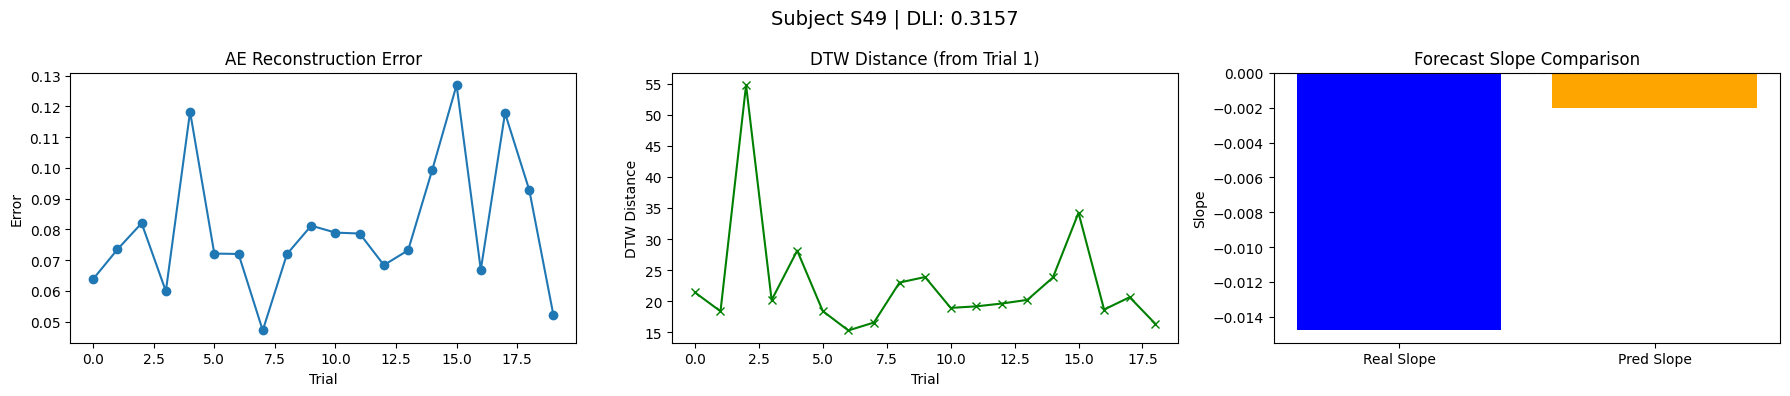

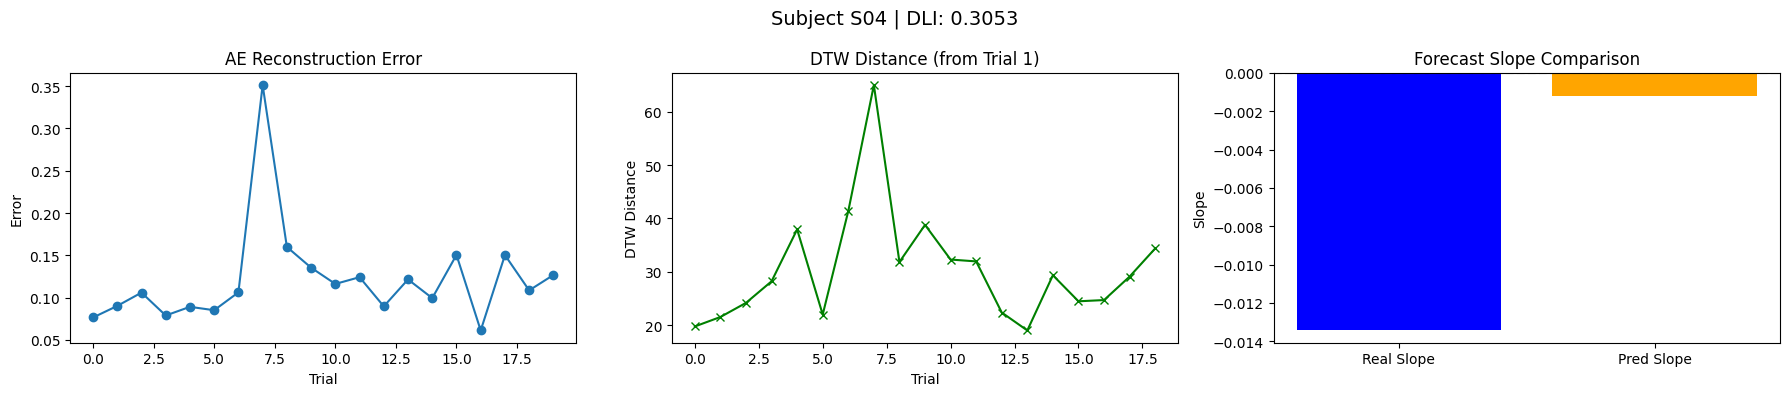

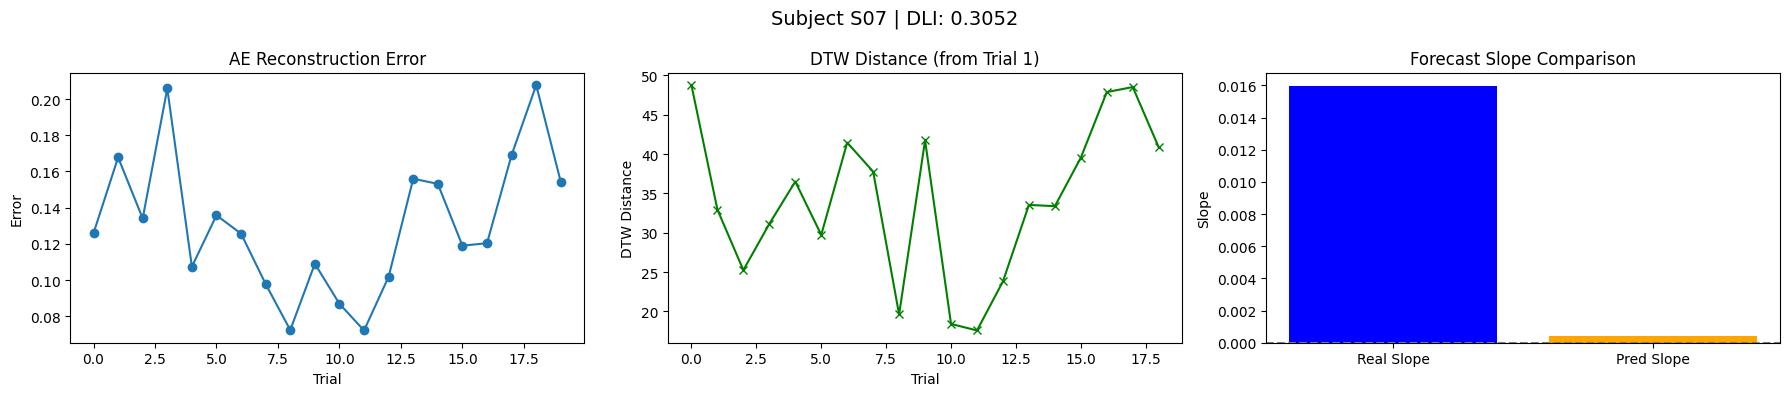

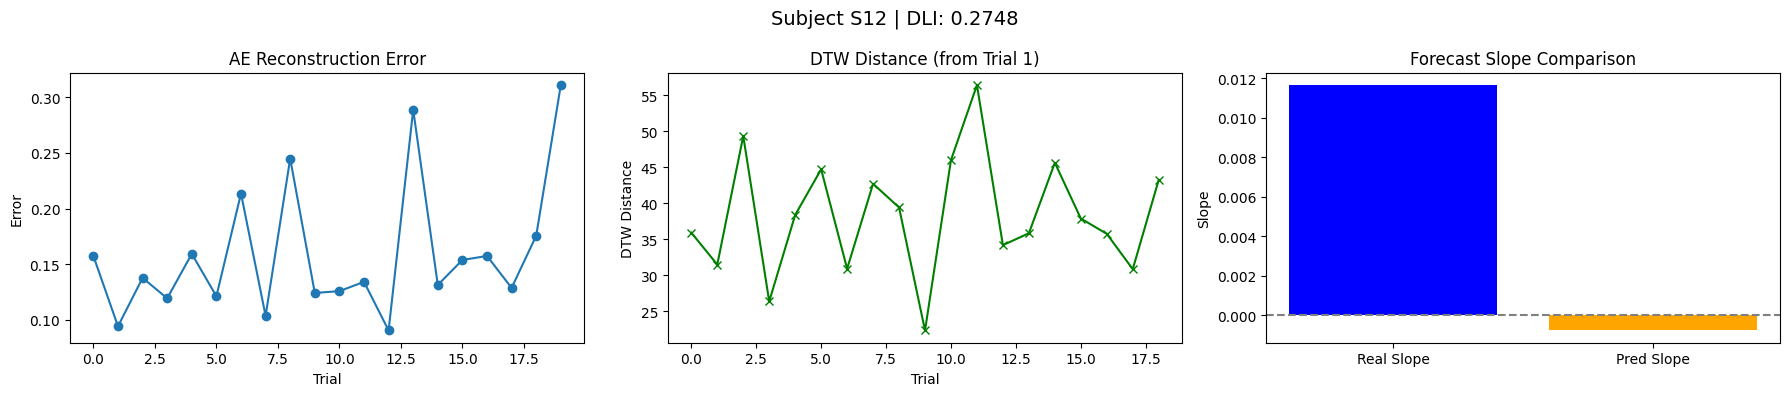

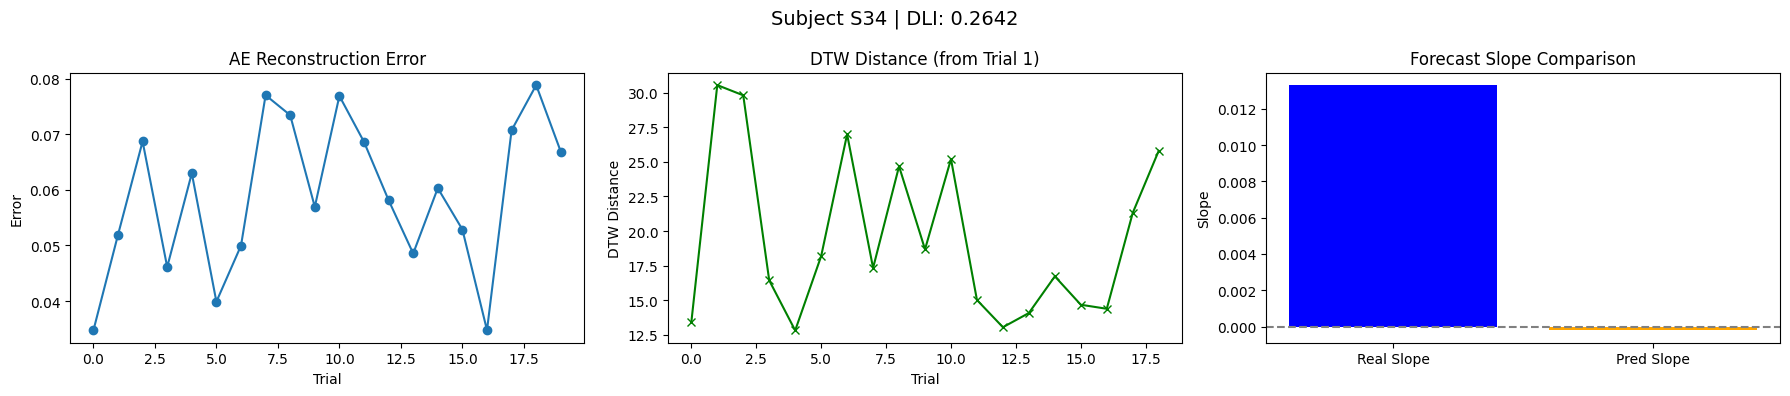

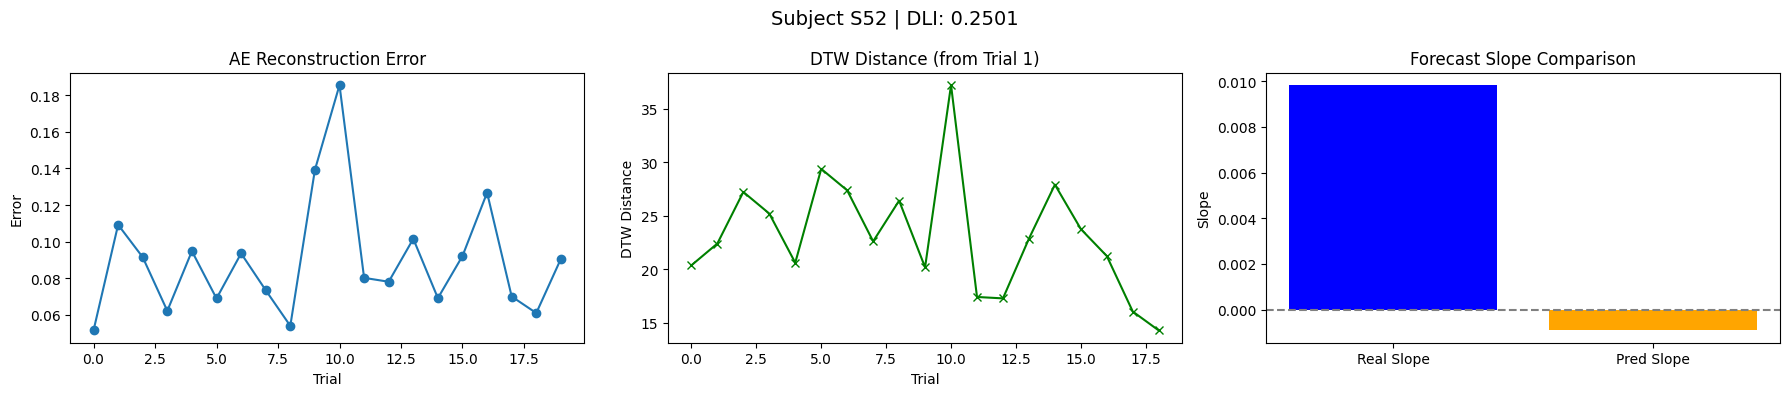

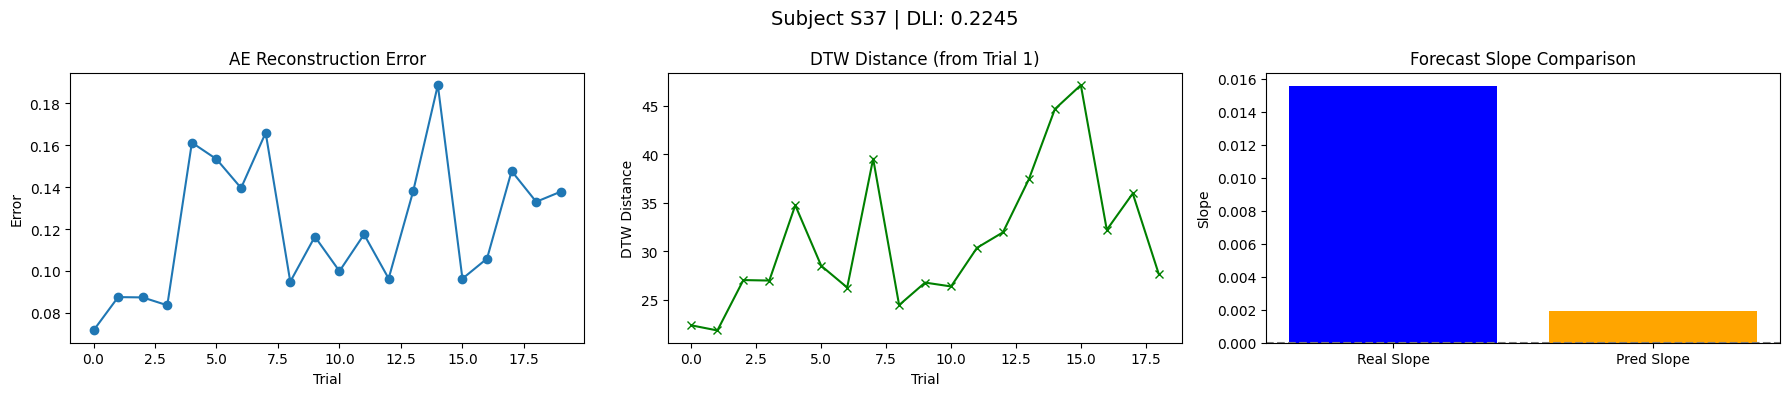

In [85]:
for sid in sorted_dli:
    plot_subject_learning_panel(
        subject_id=sid,
        subject_info=subject_data[sid],
        dli_score=dli[sid],
    )

In [100]:
all_llm_results = {}

for sid in dli:
    subject_info = subject_data[sid]
    dli_score = dli.get(sid, 0)

    prompt = generate_llm_prompt_continuous(sid, subject_info, dli_score)
    response = call_llm_api(prompt)

    all_llm_results[sid] = {
        "prompt": prompt,
        "response": response,
        "dli_score": round(dli_score, 4)
    }

    print(f"📋 Subject {sid} (DLI: {round(dli_score, 4)}) LLM verdict:\n{response}\n{'-'*80}")

📋 Subject S02 (DLI: 0.5229) LLM verdict:
The subject's learning potential across the trials can be evaluated by analyzing the results from the three machine learning models and the Differential Learning Index (DLI).

1. **Autoencoder**: The reconstruction error shows a slight reduction from the first to the last trial, with a delta of 0.01894. This indicates some level of learning, as the model's ability to reconstruct the movement improves slightly over time.

2. **Forecasting Transformer**: The real slope of gait evolution is 0.0, and the predicted slope is -0.00017, resulting in a minimal gap of 0.00017. This suggests that the model's prediction is very close to the actual gait evolution, indicating stable performance but not necessarily strong evidence of learning.

3. **Dynamic Time Warping (DTW)**: The DTW distance remains consistently at 0.0 across all trials, suggesting no change in the shape of the gait signal. This implies that there is no observable adaptation or learning in

In [101]:
import re
import pandas as pd

def extract_llm_and_dli_classification(llm_results, dli_scores):
    extracted = []

    for sid, result in llm_results.items():
        response = result["response"]

        # Extract LLM numerical learning potential score
        score_match = re.search(r"Learning Potential Score:\s*([0-1](?:\.\d+)?)", response)
        llm_score = float(score_match.group(1)) if score_match else None

        # Get DLI score
        dli_score = dli_scores.get(sid, None)

        extracted.append({
            "subject_id": sid,
            "dli_score": round(dli_score, 4) if dli_score is not None else None,
            "llm_learning_score": llm_score,
            "llm_response": response
        })

    # Return a neatly formatted DataFrame
    return pd.DataFrame(extracted)

In [102]:
df_llm_cleaned = extract_llm_and_dli_classification(all_llm_results,dli)

In [103]:
df_llm_cleaned

subject_id  dli_score  llm_learning_score  \
0         S02     0.5229                0.50   
1         S03     0.5109                0.30   
2         S04     0.3053                0.30   
3         S05     0.3646                0.30   
4         S06     0.3235                0.30   
5         S07     0.3052                0.30   
6         S08     0.4349                0.40   
7         S09     0.6973                0.50   
8         S10     0.3861                0.30   
9         S11     0.4296                0.40   
10        S12     0.2748                0.30   
11        S13     0.5205                0.30   
12        S14     0.4311                0.40   
13        S15     0.6019                0.60   
14        S16     0.3987                0.40   
15        S17     0.6141                0.60   
16        S18     0.3227                0.40   
17        S19     0.3799                0.30   
18         S1     0.3959                0.40   
19        S20     0.3742                0.40   
20        S21     0.6175                0.60   
21        S22     0.5046                0.50   
22        S23     0.5867                0.60   
23        S24     0.3951                0.40   
24        S25     0.5812                0.58   
25        S26     0.4322                0.30   
26        S27     0.5402                0.54   
27        S28     0.4185                0.40   
28        S29     0.4152                0.42   
29        S30     0.5247                0.50   
30        S31     0.5321                0.53   
31        S32     0.4622                0.50   
32        S33     0.5234                0.52   
33        S34     0.2642                0.30   
34        S35     0.5081                0.50   
35        S36     0.4578                0.45   
36        S37     0.2245                0.30   
37        S38     0.4441                0.40   
38        S39     0.3618                0.36   
39        S40     0.3676                0.40   
40        S41     0.4932                0.50   
41        S42     0.5045                0.50   
42        S43     0.6067                0.61   
43        S44     0.4626                0.46   
44        S45     0.5136                0.55   
45        S46     0.3943                0.40   
46        S47     0.3739                0.40   
47        S48     0.4185                0.42   
48        S49     0.3157                0.40   
49        S50     0.4951                0.50   
50        S51     0.4284                0.43   
51        S52     0.2501                0.30   
52        S53     0.4842                0.48   
53        S54     0.3740                0.40   
54        S55     0.6182                0.62   
55        S56     0.4623                0.46   
56        S57     0.5024                0.50   

                                         llm_response  
0   The subject's learning potential across the tr...  
1   Based on the provided data, the subject's lear...  
2   Based on the provided data, the subject's lear...  
3   Based on the data provided, the subject's lear...  
4   The subject's learning potential across the 20...  
5   Based on the provided data, the subject's lear...  
6   The subject's learning potential across the 20...  
7   Based on the provided data, the subject's lear...  
8   Based on the provided data, the subject's lear...  
9   Based on the data provided, the subject's lear...  
10  Based on the provided data, the subject's lear...  
11  Based on the data provided, the subject's lear...  
12  The subject's learning potential across the 20...  
13  Based on the data provided, the subject's lear...  
14  Based on the provided data, the subject's lear...  
15  Based on the provided data, the subject's lear...  
16  The subject's learning potential across the 20...  
17  Based on the provided data, the subject's lear...  
18  The subject's learning potential across the 20...  
19  1. **Learning Potential Score: 0.4**\n\nThe su...  
20  Based on the provided data, the subjec

In [104]:
df_llm_cleaned.to_csv("llm_classification.csv")

# Results Interpretation

## Scores Correlation

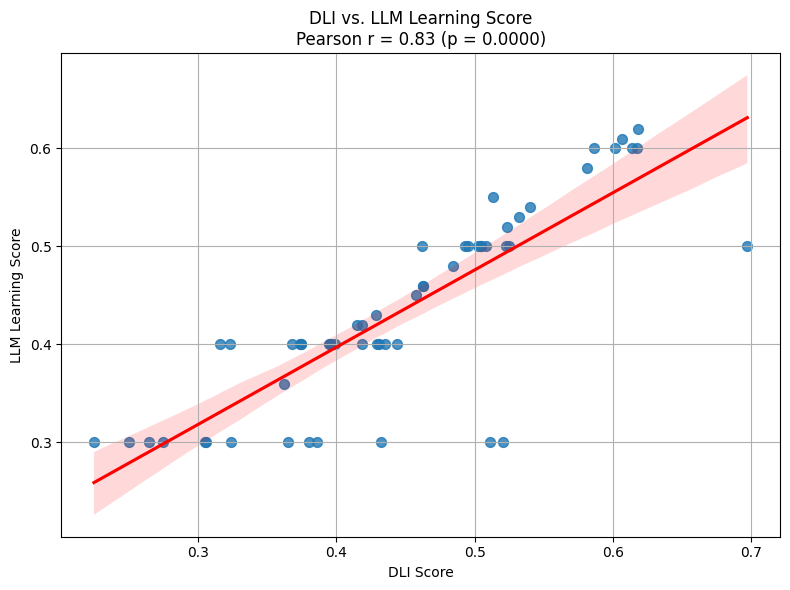

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Calculate correlation
corr_coef, p_value = pearsonr(df_llm_cleaned["dli_score"], df_llm_cleaned["llm_learning_score"])

# Plot DLI vs. LLM Learning Score
plt.figure(figsize=(8, 6))
sns.regplot(data=df_llm_cleaned, x="dli_score", y="llm_learning_score", scatter_kws={"s": 50}, line_kws={"color": "red"})
plt.title(f"DLI vs. LLM Learning Score\nPearson r = {corr_coef:.2f} (p = {p_value:.4f})")
plt.xlabel("DLI Score")
plt.ylabel("LLM Learning Score")
plt.grid(True)
plt.tight_layout()
plt.show()

## Classification

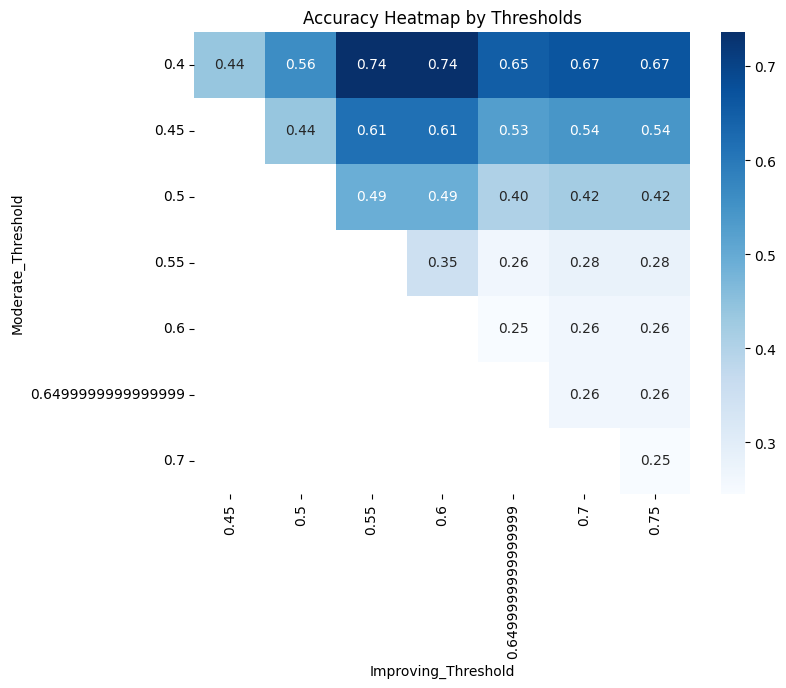

📋 Top 5 Threshold Configurations by Accuracy:
    Improving_Threshold  Moderate_Threshold  Accuracy  F1_Score
3                  0.55                 0.4  0.736842  0.743937
6                  0.60                 0.4  0.736842  0.745902
21                 0.75                 0.4  0.666667  0.634559
15                 0.70                 0.4  0.666667  0.634559
10                 0.65                 0.4  0.649123  0.623197


In [114]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Assuming llm_df already contains 'dli_score' and 'llm_category' columns

thresholds = np.arange(0.4, 0.8, 0.05)
results = []
llm_df = df_llm_cleaned


for t_improving in thresholds:
    for t_moderate in thresholds:
        if t_moderate >= t_improving:
            continue  # Ensure logical order

        def classify(score):
            if score >= t_improving:
                return "Improving"
            elif score >= t_moderate:
                return "Moderate"
            else:
                return "Stagnant"

        llm_df["dli_pred_category"] = llm_df["dli_score"].apply(classify)

        acc = accuracy_score(llm_df["llm_category"], llm_df["dli_pred_category"])
        f1 = f1_score(llm_df["llm_category"], llm_df["dli_pred_category"], average="weighted")

        results.append({
            "Improving_Threshold": t_improving,
            "Moderate_Threshold": t_moderate,
            "Accuracy": acc,
            "F1_Score": f1
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot Heatmap of Accuracy
# Plot Heatmap of Accuracy
pivot_acc = results_df.pivot(index="Moderate_Threshold", columns="Improving_Threshold", values="Accuracy")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_acc, annot=True, fmt=".2f", cmap="Blues")
plt.title("Accuracy Heatmap by Thresholds")
plt.show()

# Show Top 5 Configurations
print("📋 Top 5 Threshold Configurations by Accuracy:")
print(results_df.sort_values(by="Accuracy", ascending=False).head())

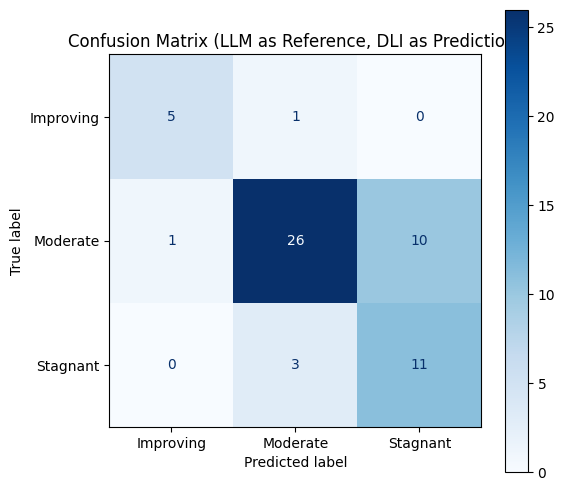

📋 Classification Report (LLM as Ground Truth, DLI as Prediction):

              precision    recall  f1-score   support

   Improving       0.83      0.83      0.83         6
    Moderate       0.87      0.70      0.78        37
    Stagnant       0.52      0.79      0.63        14

    accuracy                           0.74        57
   macro avg       0.74      0.77      0.75        57
weighted avg       0.78      0.74      0.75        57



In [115]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Best Thresholds
best_improving_threshold = 0.6
best_moderate_threshold = 0.4

# Update the classify_score function accordingly
def classify_score(score):
    if score >= best_improving_threshold:
        return "Improving"
    elif score >= best_moderate_threshold:
        return "Moderate"
    else:
        return "Stagnant"


# Apply classification to both DLI and LLM scores
llm_df["dli_category"] = llm_df["dli_score"].apply(classify_score)
llm_df["llm_category"] = llm_df["llm_learning_score"].apply(classify_score)

# Generate Confusion Matrix
cm = confusion_matrix(llm_df["llm_category"], llm_df["dli_category"], labels=["Improving", "Moderate", "Stagnant"])

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Improving", "Moderate", "Stagnant"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (LLM as Reference, DLI as Prediction)")
plt.show()

# Generate Classification Report
print("📋 Classification Report (LLM as Ground Truth, DLI as Prediction):\n")
labels = ["Improving", "Moderate", "Stagnant"]
print(classification_report(
    llm_df["llm_category"],
    llm_df["dli_category"],
    labels=labels,
    target_names=labels,
    zero_division=0  # Prevent division by zero warnings
))

##

## Clustering

### 1. Feature Preparation

In [117]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Extract and merge data
additional_data = []
for sid in llm_df['subject_id']:
    data = subject_data.get(sid, {})
    ae = data.get('autoencoder', {})
    forecast = data.get('forecasting', {})
    dtw = data.get('dtw', {})

    additional_data.append({
        'subject_id': sid,
        'learning_index': ae.get('learning_index', 0),
        'forecast_real_slope': forecast.get('real_slope', 0),
        'forecast_pred_slope': forecast.get('pred_slope', 0),
        'dtw_final_distance': dtw.get('final_dtw', 0),
    })

additional_df = pd.DataFrame(additional_data)
merged_df = llm_df.merge(additional_df, on='subject_id')
merged_df['forecast_gap'] = abs(merged_df['forecast_real_slope'] - merged_df['forecast_pred_slope'])

# Feature Set
features = merged_df[['dli_score', 'llm_learning_score', 'learning_index', 'forecast_gap', 'dtw_final_distance']].fillna(0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### 2. Dimensionality Reduction

In [118]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)
merged_df['pca_1'] = pca_result[:, 0]
merged_df['pca_2'] = pca_result[:, 1]

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
tsne_result = tsne.fit_transform(features_scaled)
merged_df['tsne_1'] = tsne_result[:, 0]
merged_df['tsne_2'] = tsne_result[:, 1]

### 3. Clustering and Profiling

dli_score  llm_learning_score  learning_index  \
cluster_label                                                      
Low Learners           0.344               0.362          -0.009   
Moderate Learners      0.498               0.470           0.001   

                   forecast_gap  dtw_final_distance  
cluster_label                                        
Low Learners              0.010              29.668  
Moderate Learners         0.002              15.047

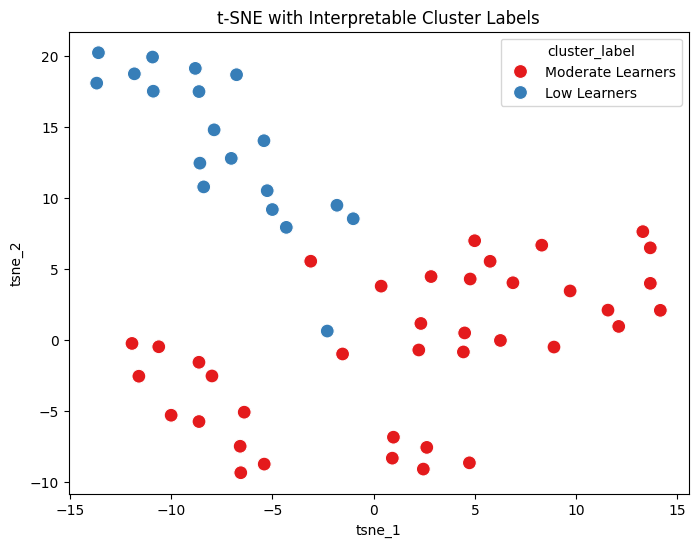

In [120]:
def label_clusters(profiles_df):
    labels = {}
    for cluster_id, row in profiles_df.iterrows():
        if row['llm_learning_score'] >= 0.6 and row['dli_score'] >= 0.6:
            labels[cluster_id] = 'High Learners'
        elif row['llm_learning_score'] >= 0.4 or row['dli_score'] >= 0.4:
            labels[cluster_id] = 'Moderate Learners'
        else:
            labels[cluster_id] = 'Low Learners'
    return labels

# Generate Labels
cluster_labels = label_clusters(cluster_profiles)

# Add Labels to DataFrame
merged_df['cluster_label'] = merged_df['cluster'].map(cluster_labels)

# 📋 Final Profile Overview
final_profiles = merged_df.groupby('cluster_label')[['dli_score', 'llm_learning_score', 'learning_index', 'forecast_gap', 'dtw_final_distance']].mean().round(3)
display(final_profiles)

# Visualize with Cluster Labels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='tsne_1', y='tsne_2', hue='cluster_label', palette='Set1', s=100)
plt.title('t-SNE with Interpretable Cluster Labels')
plt.show()

### Cluster Profile Comparison

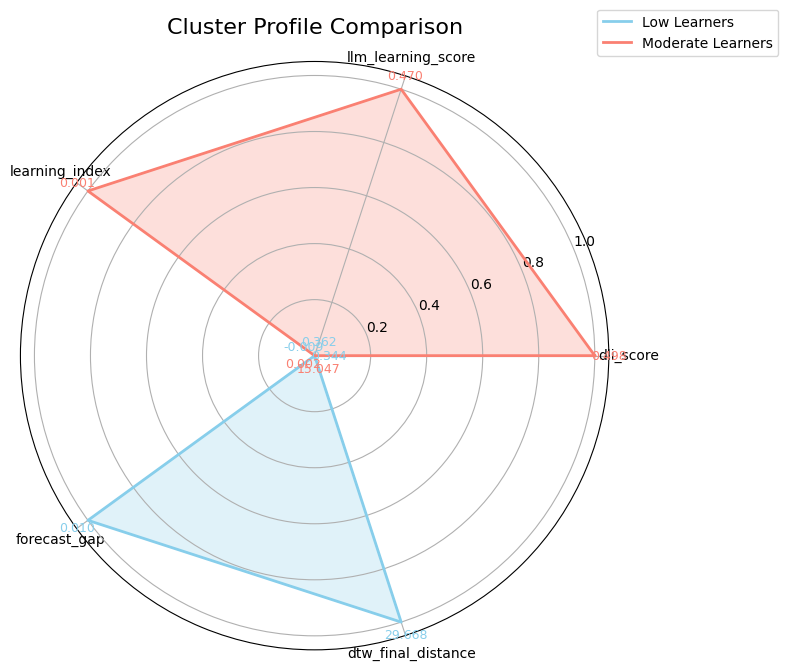

In [122]:
# Using the final_profiles dataframe directly to create the radar plot

final_profiles = df.set_index('cluster_label')  # From the provided static data

# Normalize Values for Radar Chart
features = final_profiles.columns
normalized_profiles = final_profiles.copy()

for feature in features:
    min_val = final_profiles[feature].min()
    max_val = final_profiles[feature].max()
    normalized_profiles[feature] = (final_profiles[feature] - min_val) / (max_val - min_val) if max_val != min_val else 0

# Radar Chart Setup
labels = features
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = ['skyblue', 'salmon', 'lightgreen', 'violet', 'orange']  # Extendable

for idx, (cluster, row) in enumerate(normalized_profiles.iterrows()):
    values = row.tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, color=colors[idx % len(colors)], linewidth=2, label=cluster)
    ax.fill(angles, values, color=colors[idx % len(colors)], alpha=0.25)

    # Add raw numerical values to each vertex
    for angle, value, raw_value in zip(angles, values, final_profiles.loc[cluster, features]):
        ax.text(angle, value + 0.05, f"{raw_value:.3f}", ha='center', va='center', fontsize=9, color=colors[idx % len(colors)])

# Axis Settings
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_title('Cluster Profile Comparison', size=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

# Ablation Study

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel, wilcoxon
from sklearn.metrics import cohen_kappa_score

In [124]:
def generate_llm_prompt(sid, subject_info):
    ae = subject_info.get("autoencoder", {})
    forecast = subject_info.get("forecasting", {})
    dtw = subject_info.get("dtw", {})

    rec_errors = ae.get("reconstruction_error", [])
    learning_index = ae.get("learning_index", None)

    real_slope = forecast.get("real_slope", None)
    pred_slope = forecast.get("pred_slope", None)

    final_dtw = dtw.get("final_dtw", None)
    dtw_curve = dtw.get("dtw_curve", [])

    prompt = f"""You are an expert in AI-assisted cognitive and motor function monitoring.

For the following subject, you are given the results of three machine learning models designed to detect signs of learning over 20 movement trials.

---

🔹 **Autoencoder**:
- Trial-wise reconstruction errors:
  {rec_errors}
- Learning index (error delta from first to last trial): {round(learning_index, 5) if learning_index is not None else 'N/A'}

🔹 **Forecasting Transformer**:
- Real slope of gait evolution: {round(real_slope, 5) if real_slope is not None else 'N/A'}
- Predicted slope from model: {round(pred_slope, 5) if pred_slope is not None else 'N/A'}
- Gap between real and predicted slopes: {round(abs(real_slope - pred_slope), 5) if (real_slope is not None and pred_slope is not None) else 'N/A'}

🔹 **Dynamic Time Warping (DTW)**:
- Final DTW distance from trial 1 to trial 20: {round(final_dtw, 2) if final_dtw is not None else 'N/A'}
- DTW curve over trials:
  {dtw_curve}

---

📌 **Based on the above data, answer the following:**

1. On a scale from **0.0 to 1.0**, rate the subject’s learning potential across these trials.
- *0.0 = No observable learning behavior*
- *1.0 = Strong, clear evidence of learning and adaptation*

2. Provide a brief reasoning behind your score, specifying which models influenced your judgment the most.

Be precise, but concise. Output the score on a separate line in the format:
**Learning Potential Score: [value between 0.0 and 1.0]**
"""
    return prompt

In [125]:
import re

def extract_llm_score(response):
    """
    Extracts the continuous learning potential score from the LLM response.
    Looks for the line starting with 'Learning Potential Score:'.

    Returns:
        float: The extracted score, or None if not found.
    """
    match = re.search(r"Learning Potential Score:\s*([\d\.]+)", response, re.IGNORECASE)
    if match:
        try:
            return float(match.group(1))
        except ValueError:
            return None
    return None

In [126]:
# Step 1: Generate Baseline (Without DLI) and With DLI Responses
baseline_results = {}
with_dli_results = {}

for sid in subject_data:
    subject_info = subject_data[sid]
    dli_score = dli.get(sid, 0)

    # Without DLI
    prompt_baseline = generate_llm_prompt(sid, subject_info)
    response_baseline = call_llm_api(prompt_baseline)
    baseline_results[sid] = {
        "prompt": prompt_baseline,
        "response": response_baseline,
        "score": extract_llm_score(response_baseline)
    }

    # With DLI
    prompt_dli = generate_llm_prompt_continuous(sid, subject_info, dli_score)
    response_dli = call_llm_api(prompt_dli)
    with_dli_results[sid] = {
        "prompt": prompt_dli,
        "response": response_dli,
        "score": extract_llm_score(response_dli)
    }

# Step 2: Build Comparison DataFrame
comparison_df = pd.DataFrame({
    "subject_id": list(baseline_results.keys()),
    "llm_score_baseline": [baseline_results[sid]["score"] for sid in baseline_results],
    "llm_score_with_dli": [with_dli_results[sid]["score"] for sid in with_dli_results]
})

In [141]:
# Optional: Extract Classifications if Available
def classify_llm_score(score):
    if score is None:
        return "Unknown"
    if score >= 0.6:
        return "Improving"
    elif score >= 0.4:
        return "Moderate"
    else:
        return "Stagnant"

comparison_df["llm_label_baseline"] = comparison_df["llm_score_baseline"].apply(classify_llm_score)
comparison_df["llm_label_with_dli"] = comparison_df["llm_score_with_dli"].apply(classify_llm_score)

In [142]:
comparison_df

subject_id  llm_score_baseline  llm_score_with_dli llm_label_baseline  \
0         S02                 0.1                0.50           Stagnant   
1         S03                 0.1                0.51           Stagnant   
2         S04                 0.3                0.30           Stagnant   
3         S05                 0.0                0.30           Stagnant   
4         S06                 0.0                0.30           Stagnant   
5         S07                 0.4                0.30           Moderate   
6         S08                 0.1                0.40           Stagnant   
7         S09                 0.2                0.50           Stagnant   
8         S10                 0.1                0.30           Stagnant   
9         S11                 0.1                0.40           Stagnant   
10        S12                 0.3                0.30           Stagnant   
11        S13                 0.1                0.52           Stagnant   
12        S14                 0.1                0.40           Stagnant   
13        S15                 0.4                0.60           Moderate   
14        S16                 0.1                0.40           Stagnant   
15        S17                 0.3                0.60           Stagnant   
16        S18                 0.6                0.30          Improving   
17        S19                 0.3                0.38           Stagnant   
18         S1                 0.4                0.40           Moderate   
19        S20                 0.6                0.40          Improving   
20        S21                 0.1                0.40           Stagnant   
21        S22                 0.2                0.30           Stagnant   
22        S23                 0.3                0.60           Stagnant   
23        S24                 0.5                0.40           Moderate   
24        S25                 0.3                0.50           Stagnant   
25        S26                 0.1                0.40           Stagnant   
26        S27                 0.4                0.54           Moderate   
27        S28                 0.2                0.40           Stagnant   
28        S29                 0.6                0.40          Improving   
29        S30                 0.2                0.50           Stagnant   
30        S31                 0.3                0.50           Stagnant   
31        S32                 0.6                0.46          Improving   
32        S33                 0.3                0.52           Stagnant   
33        S34                 0.3                0.30           Stagnant   
34        S35                 0.3                0.50           Stagnant   
35        S36                 0.4                0.45           Moderate   
36        S37                 0.3                0.30           Stagnant   
37        S38                 0.3                0.40           Stagnant   
38        S39                 0.4                0.36           Moderate   
39        S40                 0.4                0.37           Moderate   
40        S41                 0.3                0.50           Stagnant   
41        S42                 0.4                0.50           Moderate   
42        S43                 0.4                0.61           Moderate   
43        S44                 0.2                0.46           Stagnant   
44        S45                 0.4                0.50           Moderate   
45        S46                 0.4                0.40           Moderate   
46        S47                 0.3                0.37           Stagnant   
47        S48                 0.4                0.42           Moderate   
48        S49                 0.5                0.32           Moderate   
49        S50                 0.4                0.50           Moderate   
50        S51                 0.7                0.43          Improving   
51        S52                 0.5                0.

In [146]:
comparison_df.to_csv("/content/drive/MyDrive/differential_learning/comparison_df.csv")
comparison_df.to_csv("comparison_df.csv")

In [147]:
# Step 3: Statistical Analysis
t_stat, p_val = ttest_rel(comparison_df["llm_score_baseline"], comparison_df["llm_score_with_dli"])
try:
    w_stat, w_p_val = wilcoxon(comparison_df["llm_score_baseline"], comparison_df["llm_score_with_dli"])
except:
    w_stat, w_p_val = None, None

kappa = cohen_kappa_score(comparison_df["llm_label_baseline"], comparison_df["llm_label_with_dli"])

print(f"📊 Paired T-Test p-value: {p_val:.4f}")
if w_p_val is not None:
    print(f"📊 Wilcoxon Test p-value: {w_p_val:.4f}")
print(f"📊 Cohen's Kappa for Classification Agreement: {kappa:.4f}")

📊 Paired T-Test p-value: 0.0000
📊 Wilcoxon Test p-value: 0.0000
📊 Cohen's Kappa for Classification Agreement: -0.0278


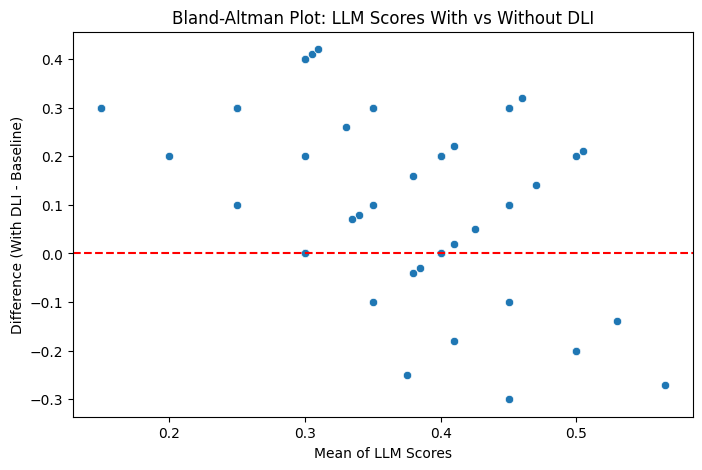

In [148]:
# Step 4: Visualization - Bland-Altman Plot
comparison_df["mean_score"] = comparison_df[["llm_score_baseline", "llm_score_with_dli"]].mean(axis=1)
comparison_df["diff_score"] = comparison_df["llm_score_with_dli"] - comparison_df["llm_score_baseline"]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=comparison_df, x="mean_score", y="diff_score")
plt.axhline(0, color='red', linestyle='--')
plt.title("Bland-Altman Plot: LLM Scores With vs Without DLI")
plt.xlabel("Mean of LLM Scores")
plt.ylabel("Difference (With DLI - Baseline)")
plt.show()

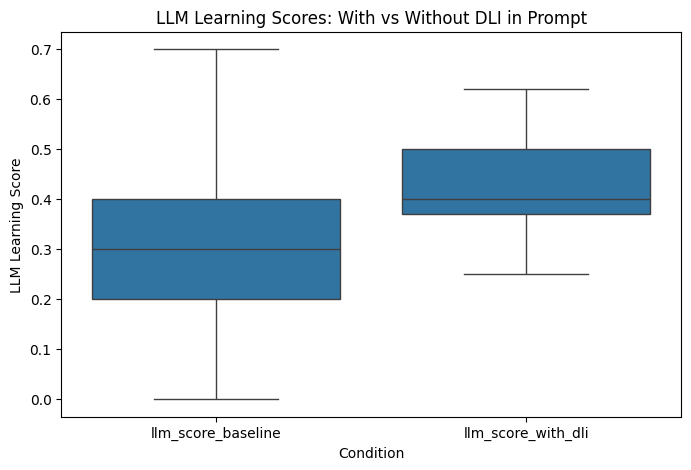

In [145]:
# Step 5: Boxplot of LLM Scores
plt.figure(figsize=(8, 5))
sns.boxplot(data=comparison_df.melt(id_vars="subject_id", value_vars=["llm_score_baseline", "llm_score_with_dli"]),
             x="variable", y="value")
plt.title("LLM Learning Scores: With vs Without DLI in Prompt")
plt.xlabel("Condition")
plt.ylabel("LLM Learning Score")
plt.show()